# Results <a class="anchor" id="top"></a>

## TOC:
* [Setup](#bullet1)
* [STATA code](#bullet2)
    - [Robustness checks](#sub-bullet2.1)
* [Results](#results)
    - [Hypothesis 1 & 2](#hypothesis_1_2)
    - [Hypothesis 3](#hypothesis_3)
    - [Lag and rolling mean effects](#sub-bullet2.3)
        - [Lag and lookback visualized](#sub-bullet2.3.1)
    - [Post limit](#sub-bullet2.4)
        - [Graphs](#sub-bullet2.4.1)
        - [Regressions](#sub-bullet2.4.2)
    - [Market cap](#sub-bullet2.5)



## Setup <a class="anchor" id="bullet1"></a>

In [1]:
# Imports
import pandas as pd
import os
import numpy as np
import time
import matplotlib.pyplot as plt


In [2]:
# Setup paths when working from either desktop or laptop
device = "desktop"
if device == "desktop":
    working_dir = r"E:\Users\Christiaan\Large_Files"
elif device == "laptop":
    working_dir = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments"
    
def join_paths(working_dir, *args):
    path = os.path.join(working_dir, *args).replace('\\', '/')
    return path

**Stata functions**

In [3]:
class Tools():
    @staticmethod
    def varlist_to_string(var_list):
        stata_string = ' '.join([str(var) for var in var_list])
        return stata_string

    @staticmethod
    def list_check(list_or_str):
        return_value = list_or_str
        if type(list_or_str).__name__ == 'str':
            return_value = [list_or_str]
            print("Converted var to list")
        return return_value

class Stata():
    # Converts a list of variables to a Stata readable string command
    @staticmethod
    def regress_code(y_vars, x_vars, function="regress", extras=""):
        stata_code = ""
        y_vars = Tools.list_check(y_vars)
        x_vars = Tools.list_check(x_vars)

        x_vars = Tools.varlist_to_string(x_vars)
        for y in y_vars:

            stata_code = stata_code + f"{function} {y} {x_vars}{extras}\n"

        return stata_code

    @staticmethod
    def grstest2_code(y_vars, x_vars, function="grstest2", extras=""):
        stata_code = ""
        y_vars = Tools.list_check(y_vars)
        x_vars = Tools.list_check(x_vars)

        x_vars = Tools.varlist_to_string(x_vars)
        for y in y_vars:
            stata_code = stata_code + f"{function} {y}, flist({x_vars}) {extras}\n"

        return stata_code

    @staticmethod
    def ttest_code(vars, test_value):
        stata_code = ""
        vars = Tools.list_check(vars)

        for var in vars:
            stata_code = stata_code + f"ttest {var} == {test_value}\n"

        return stata_code

    @staticmethod
    def run(dataframe, functions, echo=True):
#             print(f"\nSTATA CODE\n"
#                   f"||||||||||||||||||||||||||||||||||||||||||\n"
#                   f"{functions}\n"
#                   f"||||||||||||||||||||||||||||||||||||||||||\n")
            stata.pdataframe_to_data(dataframe, True)
            stata.run(f'''{functions}''', echo=echo)

    @staticmethod
    def retrieve_dataset():
        current_dataset = stata.pdataframe_from_data()
        return current_dataset


**Function to loop result files**

Function is also used to lag variables.

In [4]:
def select_tickers(selected_tickers):
    # Check for which tickers function needs to be performed. Loops all if no argument is given for 'ticker_list'
    if selected_tickers is None:
        ticker_list = ['AAPL', 'AMD', 'AMZN', 'ATVI', 'BA', 'BABA', 'BAC', 'DIS', 'F', 
               'GE', 'GME', 'IQ', 'LULU', 'MSFT', 'MU', 'NFLX', 'NVDA', 'SBUX', 
               'SHOP', 'SNAP', 'SQ', 'TLRY', 'TSLA', 'V', 'WMT']
        return ticker_list
    
    else:
        return selected_tickers
    
def csv_to_df(ticker, file_dir=join_paths(working_dir, "Thesis\DATA_MERGED")):    
    # file path
    csv_path = os.path.join(file_dir, f"{ticker}.csv").replace('\\', '/')
    
    # Read csv
    df = pd.read_csv(csv_path)
    
    return df

def lag_cols(df, lagged_cols, lag, interact_dict):
    # Check if interaction term needs to be added to dict
    cols = lagged_cols.copy()
    if interact_dict and interact_dict['lagged']:
        cols.append(interact_dict['var_name'])
    # Lag columns
    if lagged_cols is not None:
        print(cols)
        # Lag columns
        df[cols] = df[cols].shift(lag)
        return df
    else:
        print("No columns lagged")
        return df


def retrieve_results(stata_code, selected_tickers=None, lag=0, lagged_cols=None, interact_dict=False):
    # Loop selected tickers
    for ticker in select_tickers(selected_tickers):
        # read csv
        df = csv_to_df(ticker)
        
        # Create interaction term
        if interact_dict:
            df[interact_dict['var_name']] = df[interact_dict['interact_1']] * df[interact_dict['interact_2']]
        
        # lag columns
        df = lag_cols(df, lagged_cols, lag, interact_dict)
        
        # run(df, stata_code)
        Stata.run(df, stata_code)
    return df


In [5]:
# stata_code = """regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap"""
# selected_tickers=["AAPL", "TSLA"]
# lag = 2
# lagged_cols=['[twit][f2s2]method_1', '[twit][f2s2]total']
# interact_dict = {"var_name": "[f2s2]interact_sent_vol",
#                  "interact_1": "[twit][f2s2]method_1",
#                  "interact_2": "[twit][f2s2]total", "lagged": True}


# df = retrieve_results(stata_code, selected_tickers=selected_tickers, lag=lag, lagged_cols=lagged_cols, interact_dict=interact_dict)
# df[['date', '[rh]performance_1', '[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[f2s2]interact_sent_vol', '[crsp]mrktcap']].head(20)

## STATA code <a class="anchor" id="bullet2"></a>

[Go back up](#top)

### Assumptions
- When lagging sentiment data, days in weekends are considered just as valuable as week days. I.e. when lagging by 1, a monday will be predicted using the sentiment of Sunday (and not the whole weekend).

**Initializing STATA**

In [6]:
import os
os.chdir("C:/Program Files/Stata17/utilities")
from pystata import config
config.init("mp")

from pystata import stata



  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user 2-core network, expiring 25 May 2023
Serial number: 501709318376
  Licensed to: Christiaan
               Erasmus University Rotterdam

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


In [7]:
%%stata
di "Hello, World!"

Hello, World!


### Robustness checks <a class="anchor" id="sub-bullet2.1"></a>
**Fixed effects**

I check if time and firm fixed effects are needed using:

`xtset company_num date_numeric`

`testparm i.date_numeric`

`testparm i.company_num`

I find that this indeed the case, as `Prob > F = 0.0000` is the case for both firm as time fixed effects. To account for this I use the fixed effects in my model with: `i.company_num` `i.date_numeric`.

**Heteroskedasticity**

Using the following code:

`reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric`
`estat hettest`

I find that heteroskedasticity is assumed for the regression with `Prob > chi2 = 0.0000`. To adjust for this I use `vce(robust)`.

**Autocorrelation**

The following code is used to test for autocorrelation. 

`xtserial rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control`

Auto correlation is found for all four regressions. With all p-values lower than `Prob > F = 0.0072`

**Solution**

To solve the above, I use fixed effects and add `vce(robust)` to the regression.

Next we run the regression, using the firm and time fixed effects.
This is done using the command
- `areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol i.company_num, absorb(date_numeric)`

This command is the same as
- `regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol i.company_num i.date_numeric`

Except for the fact that all days `date_numeric` are absorbed.

**Preparing main dataframe**

In [8]:
def change_cols(df, cols, lag=1, rolling=1):
    df[cols] = df.groupby('[rh]ticker')[cols].shift(lag)
    
    df[cols] = df.groupby('[rh]ticker', as_index=False)[cols].rolling(rolling).mean()[cols]
    
#     df.dropna(subset=['[rh]dayname'], inplace=True)

    return df   
    

In [9]:
pd.set_option('display.max_rows', 500)
def get_regression_df():
    # Reading in main csv
    csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\DATA_MERGED\all_companies\all_companies.csv"
    df = pd.read_csv(csv_path)

    # Converting date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Adding price points to the weekend
    cols = ['[crsp]mrktcap']
    df[cols] = df.groupby('[rh]ticker')[cols].ffill()

    # Lagging control variables
    df['[taq]price_control'] = df.groupby('[rh]ticker')['[taq]returns'].shift(1) # This is lagged stock return control var

    df['[crsp]mrktcap_control'] = df.groupby('[rh]ticker')['[crsp]mrktcap'].shift(1)

    return df


In [10]:
# Repeatable STATA code
stata_code_base = """gen date_numeric = date(date, "YMD")
format date_numeric %td

encode rhticker, gen(company_num)
#xtset company_num date_numeric
tsset company_num date_numeric
"""

**Summary statistics** <a class="anchor" id="summary_stats"></a>

In order to run the code below, please first run the codeblock containing the `nt_rt()` function. It can be found [here](#ntrt_func).

In [25]:
custom_code = """
summarize rhperformance_1 NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control, detail

"""
stata_code = stata_code_base + custom_code

df_input = get_regression_df().copy()

sentiment_col = '[twit][f2s2]method_1'
volume_col = '[twit][f2s2]total'
interaction_col = '[f2s2]interact_sent_vol'

# Creating interaction term
df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

# Lag and/or rolling
lagged_cols=[sentiment_col, volume_col, interaction_col]
df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

# Add NT/RT ratio, column is 'NT/RT'
df_input = nt_rt(df_input)
    
# # Filter out day-ticker combinations with less than 10 posts
# df_input = df_input[df_input[volume_col] > threshold]
df_input.dropna(subset=['[rh]performance_1', sentiment_col, interaction_col, '[taq]price_control'], inplace=True)
Stata.run(df_input, stata_code, echo=False)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 09may2018 to 13aug2020, but with gaps
         Delta: 1 day

. 
. #summarize rhperformance_1 NTRT twitf2s2method_1 twitf2s2total f2s2interact_s
> ent_vol crspmrktcap_control taqprice_control 
Unknown #command
. summarize rhperformance_1 NTRT twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control, detail

                       rhperformance_1
-------------------------------------------------------------
      Percentiles      Smallest
 1%    -.0164072      -.1122662
 5%    -.0077863      -.1040748
10%    -.0053006      -.0754163       Obs              13,517
25%    -.0024647      -.0650998       Sum of wgt.      13,517

50%    -.0001045                      Mean           .0014635
        

In [ ]:
# df_input = df_input[df_input['[rh]ticker'].isin(['TSLA', 'AMZN', 'AAPL', 'MSFT', 'NFLX', 'NVDA'])]
# df_input = df_input[~df_input['[rh]ticker'].isin(['IQ', 'GE'])]
# df_input.groupby('[rh]ticker').mean()['[crsp]mrktcap'].rank(method='average')
# df_input.reset_index(inplace=True)

## Results <a class="anchor" id="results"></a>

### Hypothesis 1 & 2 <a class="anchor" id="hypothesis_1_2"></a>

**Twitter** <a class="anchor" id="run_twitvader"></a>


*Regression for Twitter with VADER sentiment*

In [52]:
def run_twitvader(threshold=0):
    custom_code = """
    #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    #reg taqbs_total twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [53]:
run_twitvader(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =     13,517
                                                F(586, 12929)     =          .
            

      21397  |   .0012887   .0037329     0.35   0.730                 .0048504
      21398  |   .0001309   .0057965     0.02   0.982                 .0004925
      21399  |  -.0024412    .003885    -0.63   0.530                -.0091882
      21402  |   .0004895   .0034928     0.14   0.889                 .0018425
      21403  |  -.0003943   .0035751    -0.11   0.912                 -.001516
      21404  |  -.0032817    .003466    -0.95   0.344                -.0126172
      21406  |  -.0005206   .0039167    -0.13   0.894                -.0020017
      21409  |  -.0002086   .0032586    -0.06   0.949                 -.000785
      21410  |  -.0009914   .0034563    -0.29   0.774                -.0037317
      21411  |   .0005743   .0036122     0.16   0.874                 .0022082
      21412  |  -.0003787   .0043392    -0.09   0.930                -.0014253
      21413  |  -.0012066   .0034857    -0.35   0.729                -.0046391
      21416  |   .0033852   .0056913     0.59   0.55

      21634  |  -.0000628   .0033243    -0.02   0.985                -.0002415
      21635  |  -.0007165   .0034426    -0.21   0.835                -.0028115
      21636  |  -.0046408   .0039396    -1.18   0.239                -.0182096
      21637  |  -.0047783   .0035415    -1.35   0.177                -.0187491
      21640  |  -.0029065   .0034304    -0.85   0.397                -.0114044
      21641  |  -.0002459    .003725    -0.07   0.947                -.0009648
      21642  |  -.0042293   .0032585    -1.30   0.194                -.0165951
      21643  |  -.0004874   .0046488    -0.10   0.916                -.0019127
      21644  |  -.0029505   .0033451    -0.88   0.378                -.0115773
      21647  |  -.0017424   .0035046    -0.50   0.619                -.0066989
      21648  |  -.0022168   .0032206    -0.69   0.491                -.0085229
      21649  |  -.0032149   .0032061    -1.00   0.316                -.0123602
      21650  |  -.0018152   .0033142    -0.55   0.58

      21815  |  -.0028002   .0031919    -0.88   0.380                -.0109876
      21816  |   -.002479   .0033167    -0.75   0.455                -.0097272
      21817  |  -.0019555   .0032084    -0.61   0.542                -.0076731
      21818  |  -.0026452   .0032303    -0.82   0.413                -.0103792
      21819  |  -.0021699   .0032089    -0.68   0.499                -.0085144
      21822  |  -.0016407   .0031796    -0.52   0.606                -.0063078
      21823  |   -.002183   .0031719    -0.69   0.491                -.0085657
      21824  |  -.0030396   .0031981    -0.95   0.342                -.0119267
      21825  |  -.0023407   .0031787    -0.74   0.462                -.0091846
      21826  |  -.0029198   .0031689    -0.92   0.357                -.0114566
      21829  |  -.0029484   .0031625    -0.93   0.351                -.0113358
      21830  |  -.0030607   .0031794    -0.96   0.336                -.0117673
      21831  |  -.0038266   .0032099    -1.19   0.23

      21994  |   .0129011   .0053051     2.43   0.015                 .0496004
      21997  |   .0115288   .0053547     2.15   0.031                 .0443243
      21998  |   .0078593   .0050206     1.57   0.118                 .0302166
      21999  |   .0113411   .0056542     2.01   0.045                 .0436029
      22000  |   .0084463   .0060457     1.40   0.162                 .0324731
      22001  |   .0011769   .0043619     0.27   0.787                 .0045247
      22004  |  -.0010882   .0037919    -0.29   0.774                -.0041838
      22005  |   .0053637   .0036809     1.46   0.145                 .0210463
      22006  |   .0032487   .0033712     0.96   0.335                 .0127473
      22007  |   .0048245   .0039477     1.22   0.222                 .0189303
      22008  |   .0031529   .0033856     0.93   0.352                 .0123715
      22011  |  -.0046768   .0034931    -1.34   0.181                -.0183508
      22012  |  -.0016033   .0033578    -0.48   0.63


.     #reg taqbs_total twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crs
> pmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) b
> eta
Unknown #command
. 
.     
. 


*Regression for Twitter with finBERT sentiment*

In [115]:
custom_code = """
#areg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num, absorb(date_numeric)
reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
"""
stata_code = stata_code_base + custom_code

df_input = get_regression_df().copy()

sentiment_col = '[twit][f2BERT]method_1'
volume_col = '[twit][f2BERT]total'
interaction_col = '[f2BERT]interact_sent_vol'

# Creating interaction term
df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

# Lag and/or rolling
lagged_cols=[sentiment_col, volume_col, interaction_col]
df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

# df_input = df_input[df_input[volume_col] > 10]


Stata.run(df_input, stata_code)



. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (strongly balanced)
 Time variable: date_numeric, 01may2018 to 31aug2020
         Delta: 1 day

. 
. #areg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_
> vol crspmrktcap_control taqprice_control i.company_num, absorb(date_numeric)
Unknown #command
. reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vo
> l crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robu
> st) beta

Linear regression                               Number of obs     =     10,910
                                                F(586, 10322)     =          .
                                                Prob > F          =          .
                                                R-squared         =     0.1327
                

      21447  |    .006744   .0030827     2.19   0.029                 .0251872
      21448  |  -.0063017    .006424    -0.98   0.327                -.0235353
      21451  |  -.0019106   .0020016    -0.95   0.340                -.0073204
      21452  |   .0019688   .0027517     0.72   0.474                 .0077297
      21453  |  -.0001417   .0023914    -0.06   0.953                -.0005562
      21454  |    .001346   .0024763     0.54   0.587                 .0052843
      21455  |    .002059   .0023934     0.86   0.390                 .0080836
      21458  |  -.0020402   .0047902    -0.43   0.670                -.0078173
      21459  |  -.0058141   .0040566    -1.43   0.152                -.0222772
      21460  |   .0013026   .0027337     0.48   0.634                 .0049912
      21461  |   .0025696   .0031346     0.82   0.412                 .0098456
      21462  |   .0032401   .0039569     0.82   0.413                 .0124149
      21465  |   .0008241   .0029391     0.28   0.77

      21635  |   .0024035   .0025775     0.93   0.351                 .0087372
      21636  |     -.0023   .0037553    -0.61   0.540                -.0083611
      21637  |  -.0027374   .0029069    -0.94   0.346                -.0099514
      21640  |  -.0013816   .0020375    -0.68   0.498                -.0055516
      21641  |   .0009166   .0019189     0.48   0.633                  .003683
      21642  |  -.0005009   .0019878    -0.25   0.801                -.0019664
      21643  |   .0025016   .0042676     0.59   0.558                 .0100519
      21644  |   .0001472   .0023267     0.06   0.950                 .0005916
      21647  |   .0025117   .0023344     1.08   0.282                 .0098611
      21648  |   .0004061   .0019964     0.20   0.839                 .0016318
      21649  |  -.0001719   .0019367    -0.09   0.929                -.0006908
      21650  |   .0012921   .0021046     0.61   0.539                 .0053083
      21651  |   .0014651   .0029409     0.50   0.61

      21797  |   .0014076   .0042765     0.33   0.742                 .0046718
      21798  |  -.0045564   .0047843    -0.95   0.341                -.0151229
      21801  |   .0033318    .004037     0.83   0.409                  .012112
      21802  |   .0021115   .0022425     0.94   0.346                  .007886
      21803  |   .0002634   .0026171     0.10   0.920                 .0010092
      21804  |   .0008873    .002326     0.38   0.703                 .0033137
      21805  |   .0002986   .0019052     0.16   0.875                 .0011151
      21808  |   .0004708   .0019524     0.24   0.809                 .0018039
      21809  |  -.0000506   .0018307    -0.03   0.978                -.0001939
      21810  |   .0001739   .0018863     0.09   0.927                 .0006493
      21811  |   .0011111    .001913     0.58   0.561                  .004039
      21812  |    .002199   .0019758     1.11   0.266                 .0079938
      21815  |   .0004406   .0018889     0.23   0.81

      22028  |  -.0001107   .0023497    -0.05   0.962                -.0004742
      22029  |  -.0004138   .0027428    -0.15   0.880                -.0017721
      22032  |   .0026299   .0028232     0.93   0.352                 .0103249
      22033  |   .0040073   .0024096     1.66   0.096                 .0153541
      22034  |     .00119   .0037854     0.31   0.753                 .0045595
      22035  |   .0026282   .0026323     1.00   0.318                   .01007
      22036  |  -.0002409   .0028928    -0.08   0.934                -.0009231
      22039  |   .0017162   .0021496     0.80   0.425                 .0068962
      22040  |   .0024279   .0026299     0.92   0.356                  .009532
      22041  |   .0017365   .0023486     0.74   0.460                 .0066535
      22042  |  -.0006043   .0021758    -0.28   0.781                -.0023155
      22043  |  -.0001112   .0024858    -0.04   0.964                -.0004259
      22046  |   .0090416   .0021407     4.22   0.00

**Reddit**

*Regression for Reddit with VADER sentiment*

In [116]:
custom_code = """
#areg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, absorb(date_numeric)
reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

"""
stata_code = stata_code_base + custom_code

df_input = get_regression_df().copy()

sentiment_col = '[red][m2f2s2]method_1'
volume_col = '[red][m2f2s2]total'
interaction_col = '[m2f2s2]interact_sent_vol'

# Creating interaction term
df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

# Lag and/or rolling
lagged_cols=[sentiment_col, volume_col, interaction_col]
df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

Stata.run(df_input, stata_code)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (strongly balanced)
 Time variable: date_numeric, 01may2018 to 31aug2020
         Delta: 1 day

. 
. #areg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, absorb(date_numeric)
Unknown #command
. reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =     11,160
                                                F(586, 10572)     =          .
                                                Prob > F          =          .
                                                R-squared         =     0.1258
                    

      21586  |  -.0039038   .0043436    -0.90   0.369                -.0138837
      21587  |  -.0045211   .0050194    -0.90   0.368                -.0164959
      21588  |   -.003715   .0044131    -0.84   0.400                -.0128605
      21591  |  -.0017196   .0046649    -0.37   0.712                 -.005435
      21592  |   -.004384   .0044903    -0.98   0.329                -.0151763
      21593  |  -.0037564   .0045346    -0.83   0.407                -.0137058
      21594  |  -.0055692   .0044495    -1.25   0.211                  -.02131
      21595  |  -.0059087   .0043922    -1.35   0.179                -.0220902
      21599  |  -.0047457   .0043736    -1.09   0.278                -.0173153
      21600  |  -.0014947   .0046778    -0.32   0.749                -.0050288
      21601  |  -.0030984   .0044281    -0.70   0.484                -.0110192
      21602  |  -.0040529   .0044838    -0.90   0.366                  -.01403
      21605  |  -.0043518   .0044777    -0.97   0.33

      21788  |  -.0046606    .004392    -1.06   0.289                 -.017424
      21789  |  -.0039586    .004452    -0.89   0.374                -.0147997
      21790  |   -.004972   .0045325    -1.10   0.273                -.0185883
      21791  |  -.0037327    .004435    -0.84   0.400                -.0146031
      21795  |  -.0016974   .0044339    -0.38   0.702                -.0060367
      21796  |  -.0040015   .0044972    -0.89   0.374                -.0149599
      21797  |  -.0035415   .0051354    -0.69   0.490                -.0132403
      21798  |  -.0079011   .0054214    -1.46   0.145                 -.029539
      21801  |  -.0007272    .005333    -0.14   0.892                -.0025863
      21802  |   -.002548    .004483    -0.57   0.570                -.0099683
      21803  |  -.0046843    .004666    -1.00   0.315                -.0183259
      21804  |  -.0052223   .0045197    -1.16   0.248                -.0199825
      21805  |  -.0047173   .0043775    -1.08   0.28

      21952  |  -.0047491   .0045205    -1.05   0.293                -.0177549
      21955  |  -.0015049   .0046266    -0.33   0.745                -.0052095
      21956  |  -.0028809   .0045927    -0.63   0.530                -.0110236
      21957  |  -.0053213   .0044517    -1.20   0.232                -.0198942
      21958  |  -.0064081   .0046704    -1.37   0.170                -.0250701
      21959  |  -.0052681   .0044984    -1.17   0.242                -.0192215
      21963  |  -.0046697   .0045212    -1.03   0.302                -.0166073
      21964  |  -.0054409   .0045676    -1.19   0.234                -.0203413
      21965  |  -.0055328   .0044153    -1.25   0.210                -.0221101
      21966  |  -.0050397   .0044344    -1.14   0.256                -.0188413
      21969  |  -.0062254   .0045008    -1.38   0.167                -.0215506
      21970  |   -.007334   .0045128    -1.63   0.104                -.0274188
      21971  |   .0007062    .004449     0.16   0.87

      22112  |  -.0008627   .0060359    -0.14   0.886                -.0033749
      22113  |  -.0047827   .0045229    -1.06   0.290                -.0187112
      22116  |  -.0049733   .0044372    -1.12   0.262                 -.018146
      22117  |  -.0010216   .0049076    -0.21   0.835                -.0038192
      22118  |   -.003372   .0045006    -0.75   0.454                -.0129027
      22119  |  -.0024405   .0046374    -0.53   0.599                -.0084483
      22120  |  -.0039692   .0044536    -0.89   0.373                -.0151878
      22123  |  -.0026484   .0044929    -0.59   0.556                 -.009663
      22124  |    -.00472   .0045139    -1.05   0.296                -.0184658
      22125  |  -.0067127   .0046971    -1.43   0.153                -.0256857
      22126  |  -.0060462   .0044424    -1.36   0.174                -.0215029
      22127  |  -.0003173   .0048082    -0.07   0.947                -.0012682
      22130  |   .0071803   .0061926     1.16   0.24

*Regression for Reddit with finBERT sentiment*

In [118]:
custom_code = """
#areg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num, absorb(date_numeric)
reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

"""
stata_code = stata_code_base + custom_code

df_input = get_regression_df().copy()

sentiment_col = '[red][m2f2BERT]method_1'
volume_col = '[red][m2f2BERT]total'
interaction_col = '[m2f2BERT]interact_sent_vol'

# Creating interaction term
df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

# Lag and/or rolling
lagged_cols=[sentiment_col, volume_col, interaction_col]
df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

Stata.run(df_input, stata_code)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (strongly balanced)
 Time variable: date_numeric, 01may2018 to 31aug2020
         Delta: 1 day

. 
. #areg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_s
> ent_vol crspmrktcap_control taqprice_control i.company_num, absorb(date_numer
> ic)
Unknown #command
. reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sen
> t_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(
> robust) beta

Linear regression                               Number of obs     =      8,837
                                                F(586, 8249)      =          .
                                                Prob > F          =          .
                                                R-squared         =     0.1663
     

      21440  |  -.0007992   .0089727    -0.09   0.929                -.0030532
      21441  |  -.0085701   .0063828    -1.34   0.179                -.0308711
      21444  |  -.0073379   .0056447    -1.30   0.194                -.0255946
      21445  |  -.0068771   .0055543    -1.24   0.216                -.0269907
      21446  |  -.0013663   .0098395    -0.14   0.890                -.0046043
      21447  |   .0006359   .0061454     0.10   0.918                 .0024291
      21448  |  -.0119811   .0084059    -1.43   0.154                 -.045771
      21451  |  -.0077091   .0054953    -1.40   0.161                -.0286224
      21452  |  -.0043869   .0059666    -0.74   0.462                 -.016759
      21453  |  -.0063443    .005644    -1.12   0.261                -.0255448
      21454  |  -.0045708    .005775    -0.79   0.429                -.0169707
      21455  |   -.003189   .0063784    -0.50   0.617                -.0125158
      21458  |    -.00789    .008223    -0.96   0.33

      21675  |  -.0027161   .0055247    -0.49   0.623                 -.009153
      21676  |  -.0033779   .0054138    -0.62   0.533                -.0117821
      21677  |   -.000776   .0054711    -0.14   0.887                -.0026151
      21678  |  -.0053992   .0053809    -1.00   0.316                -.0194489
      21679  |  -.0054771   .0053974    -1.01   0.310                -.0191042
      21682  |  -.0054558   .0056272    -0.97   0.332                -.0170237
      21683  |   .0010184   .0057463     0.18   0.859                 .0034319
      21684  |   -.002924   .0055184    -0.53   0.596                -.0101988
      21685  |  -.0048781   .0054535    -0.89   0.371                -.0186357
      21686  |  -.0048616   .0054228    -0.90   0.370                -.0180503
      21689  |  -.0025434   .0056078    -0.45   0.650                 -.008571
      21690  |  -.0041686   .0054115    -0.77   0.441                -.0140478
      21691  |  -.0056157   .0053893    -1.04   0.29

      21860  |  -.0081176   .0054804    -1.48   0.139                -.0283141
      21861  |  -.0055356   .0054636    -1.01   0.311                 -.019308
      21864  |  -.0012716   .0056211    -0.23   0.821                -.0044354
      21865  |  -.0040629   .0054803    -0.74   0.458                -.0146352
      21866  |  -.0035329   .0057413    -0.62   0.538                -.0138655
      21867  |  -.0016305   .0056269    -0.29   0.772                -.0052951
      21868  |  -.0065162   .0054723    -1.19   0.234                -.0241935
      21871  |  -.0054326   .0056074    -0.97   0.333                 -.018949
      21872  |  -.0056077   .0054457    -1.03   0.303                -.0208204
      21873  |  -.0048236   .0053952    -0.89   0.371                -.0184272
      21874  |  -.0058473   .0054458    -1.07   0.283                -.0210631
      21875  |  -.0043353   .0055503    -0.78   0.435                -.0151215
      21878  |  -.0031385   .0059911    -0.52   0.60

      22032  |   -.005348   .0059618    -0.90   0.370                -.0198562
      22033  |  -.0010442   .0055625    -0.19   0.851                -.0042043
      22034  |  -.0059111   .0065692    -0.90   0.368                -.0231995
      22035  |  -.0050183    .005824    -0.86   0.389                -.0207036
      22036  |  -.0099607   .0061727    -1.61   0.107                -.0369825
      22039  |   -.005957   .0055206    -1.08   0.281                -.0227575
      22040  |  -.0032538     .00595    -0.55   0.584                -.0134241
      22041  |  -.0069363   .0056468    -1.23   0.219                -.0272231
      22042  |  -.0082042   .0055248    -1.48   0.138                -.0346423
      22043  |  -.0072423    .005629    -1.29   0.198                -.0298791
      22046  |   .0028624   .0056054     0.51   0.610                 .0109351
      22047  |  -.0058308   .0054324    -1.07   0.283                 -.024056
      22048  |  -.0011504   .0056019    -0.21   0.83

### Hypothesis 3 <a class="anchor" id="hypothesis_3"></a>

To compare noise traders with retail traders, a ratio is created. This ratio has the noise trader activity `[rh]performance_1` in the numerator and the retail trader activity `[taq]bs_change` in the denominator.

---

The `[taq]bs_change` variable is calculated as such, that is most closely resembles the `[rh]performance_1` variable:

`df['bs_change'] = (df['buy'] - df['sell']) / df['total_bs'].rolling(5).mean()`

 

---
The formula to calculate the noise trader / retail trader activity will look like this:

- $\text{Performance ratio NT/RT}_{t0} =  \frac{\text{[rh]performance_1}_{t0}}{\text{[taq]bs_change}_{t0}}$

Before calculating this ratio, a few adjustments are made to the data. This is done to make the data more comparable.
- The data is first scaled on a scale form 0 to 1.
- Subsequently, the mean is subtracted from both data sets. 

This transformation makes the data comparable and usable for the ratio above.

A last tweak is made to the function, which is adding 1 to all values before dividing:
- $\text{Performance ratio NT/RT}_{t0} =  \frac{1 + \text{[rh]performance_1}_{t0}}{1 + \text{[taq]bs_change}_{t0}} - 1$


This will eventually lead to a graph like this, where NT/RT will go up if NT activty goes up relative to RT activity:

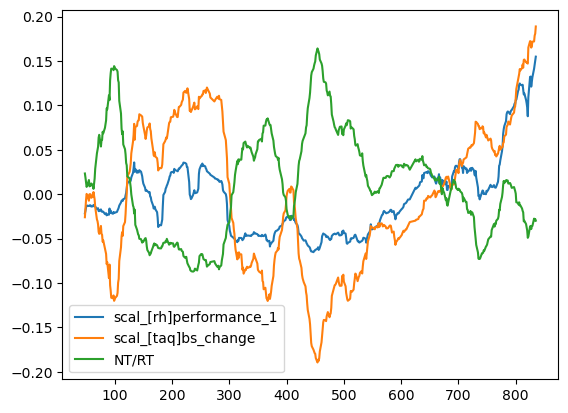

<a class="anchor" id="ntrt_func"></a>

The nt_rt function below is also used in the summary statistics part, which can be found [here](#summary_stats).

In [23]:
# Functions to calc noise trader / retail trader ratio data
from sklearn.preprocessing import MinMaxScaler

def scale_01(df, col_name, name_prefix="scal_"):
   
    # create a MinMaxScaler object
    scaler = MinMaxScaler()

    # fit and transform the data in the 'col_name' column
    # df[f"{name_prefix}{col_name}"] = scaler.fit_transform(df[[col_name]])
    df[f"{name_prefix}{col_name}"] = df.groupby('[rh]ticker')[col_name].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

    return df

# Adds nt_rt column to dataframe
def nt_rt(df):
    # Taking scaled value
    df = scale_01(df, '[rh]performance_1', name_prefix="scal_")
    df = scale_01(df, '[taq]bs_change', name_prefix="scal_")

    # Subtracting average
    df['scal_[rh]performance_1'] = df['scal_[rh]performance_1'] - df['scal_[rh]performance_1'].mean()
    df['scal_[taq]bs_change'] = df['scal_[taq]bs_change'] - df['scal_[taq]bs_change'].mean()
    
    # Calculate NT/RT ratio
    df['NT/RT'] = (1 + df['scal_[rh]performance_1']) / (1 + df['scal_[taq]bs_change']) - 1
    
    return df

**<u>Robustness checks</u>**

I again do robustness checks and check and find the following.

**Fixed effects**

I check if time and firm fixed effects are needed using:

`xtset company_num date_numeric`

`testparm i.date_numeric`

`testparm i.company_num`

I find that this indeed the case, as `Prob > F = 0.0000` is the case for both firm as time fixed effects. To account for this I use the fixed effects in my model with: `i.company_num` `i.date_numeric`.

**Heteroskedasticity**

Using the following code:

`reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric`
`estat hettest`

I find that heteroskedasticity is assumed for the regression with `Prob > chi2 = 0.0000`. To adjust for this I use `vce(robust)`.

**Autocorrelation**

The following code is used to test for autocorrelation. 

`xtserial rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control`

Auto correlation is found for all four regressions. With `Prob > F = 0.0000`

**Solution**

To solve the above, I use fixed effects and add `vce(robust)` to the regression.

**<u>Twitter</u>**


*Regression for Twitter with VADER sentiment*

In [30]:
def run_twitvader(threshold=0, lag=1, rolling=1):
    custom_code = """
    reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [31]:
run_twitvader(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap
> _control taqprice_control i.company_num i.date_numeric, vce(robust) beta

Linear regression                               Number of obs     =     13,517
                                                F(586, 12929)     =          .
                                                Prob > F          =          .
                                                R-squared         =     0.7385
                                                Root MSE          =     .09961

------------------------------------------------------------------------------
             |               Robust
     

      21497  |   .0018234   .0397837     0.05   0.963                 .0004029
      21500  |  -.0329188   .0339165    -0.97   0.332                -.0071215
      21501  |   .0173621   .0305596     0.57   0.570                 .0038367
      21502  |  -.0135151    .028486    -0.47   0.635                -.0029866
      21503  |  -.0035933   .0303971    -0.12   0.906                -.0007941
      21504  |  -.0013639   .0369571    -0.04   0.971                -.0003014
      21507  |  -.0284178   .0312008    -0.91   0.362                -.0062798
      21508  |   .0282765   .0322887     0.88   0.381                 .0062486
      21509  |  -.0031137   .0290531    -0.11   0.915                -.0006881
      21511  |   .0131105   .0289167     0.45   0.650                 .0028972
      21514  |    .005468   .0294684     0.19   0.853                 .0012332
      21515  |   -.008347   .0335897    -0.25   0.804                -.0018825
      21516  |  -.0080298   .0334137    -0.24   0.81

      21796  |    .042655   .0378729     1.13   0.260                 .0092279
      21797  |   .0746119   .0357426     2.09   0.037                 .0164879
      21798  |  -.0191987   .0343952    -0.56   0.577                -.0042426
      21801  |    .016596   .0364898     0.45   0.649                 .0037429
      21802  |  -.0151797    .029213    -0.52   0.603                -.0034235
      21803  |   .0088149   .0321129     0.27   0.784                  .001988
      21804  |   .0217545   .0316948     0.69   0.492                 .0049063
      21805  |   .0378199   .0317238     1.19   0.233                 .0085295
      21808  |    -.00693   .0288416    -0.24   0.810                -.0015629
      21809  |   .0010639    .029345     0.04   0.971                 .0002351
      21810  |  -.0210373   .0287884    -0.73   0.465                -.0047445
      21811  |  -.0053583   .0293859    -0.18   0.855                -.0012085
      21812  |   .0153077   .0313342     0.49   0.62

      22028  |  -.0664842   .0300369    -2.21   0.027                -.0149942
      22029  |  -.0884878   .0301282    -2.94   0.003                -.0199567
      22032  |  -.0644826   .0328909    -1.96   0.050                -.0145428
      22033  |  -.0474255   .0327328    -1.45   0.147                -.0106959
      22034  |  -.0728551   .0311277    -2.34   0.019                 -.016431
      22035  |  -.0828659   .0302975    -2.74   0.006                -.0186888
      22036  |  -.1023669    .032715    -3.13   0.002                -.0230868
      22039  |  -.0517718   .0378576    -1.37   0.171                -.0116761
      22040  |   -.035932   .0292391    -1.23   0.219                -.0081037
      22041  |     -.0563   .0300316    -1.87   0.061                -.0126974
      22042  |  -.0335423   .0287895    -1.17   0.244                -.0075648
      22043  |  -.0551262   .0318255    -1.73   0.083                -.0124326
      22046  |    .000623   .0389183     0.02   0.98



*Regression for Twitter with finBERT sentiment*

In [32]:
def run_twitfinbert(threshold=0, lag=1, rolling=1):
    custom_code = """
    reg NTRT twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[twit][f2BERT]method_1'
    volume_col = '[twit][f2BERT]total'
    interaction_col = '[f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [33]:
run_twitfinbert(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg NTRT twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspm
> rktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) bet
> a

Linear regression                               Number of obs     =     10,910
                                                F(586, 10322)     =          .
                                                Prob > F          =          .
                                                R-squared         =     0.7228
                                                Root MSE          =     .09953

------------------------------------------------------------------------------
             |               Rob

      21504  |   .0103603   .0410587     0.25   0.801                   .00241
      21507  |  -.0317151   .0338149    -0.94   0.348                -.0075595
      21508  |    .021195   .0348276     0.61   0.543                 .0051706
      21509  |  -.0068356   .0322275    -0.21   0.832                -.0016293
      21511  |   .0166471   .0321708     0.52   0.605                 .0037746
      21514  |   .0055197   .0331327     0.17   0.868                 .0011839
      21515  |  -.0121494   .0422431    -0.29   0.774                -.0025283
      21516  |  -.0014537   .0397184    -0.04   0.971                -.0003118
      21517  |  -.0275972   .0321465    -0.86   0.391                -.0062574
      21518  |  -.0365394   .0329328    -1.11   0.267                -.0078376
      21521  |   .0261609   .0424312     0.62   0.538                 .0059318
      21522  |  -.0598045   .0362971    -1.65   0.099                -.0142547
      21524  |   -.051084   .0351514    -1.45   0.14

      21710  |   .0079055   .0367932     0.21   0.830                 .0016957
      21711  |   .0305246   .0362912     0.84   0.400                 .0069212
      21712  |  -.0207259   .0359079    -0.58   0.564                -.0045743
      21713  |  -.0372552   .0410141    -0.91   0.364                -.0079911
      21714  |  -.0218705   .0330389    -0.66   0.508                -.0046911
      21717  |  -.0293422   .0352491    -0.83   0.405                -.0064759
      21718  |   .0683602   .0449079     1.52   0.128                 .0150874
      21719  |  -.0008572   .0371261    -0.02   0.982                -.0001944
      21720  |   .0444988   .0396662     1.12   0.262                 .0103514
      21721  |   .0090518   .0347774     0.26   0.795                 .0021056
      21724  |   .0549933   .0408922     1.34   0.179                 .0114442
      21725  |   .0447065   .0348058     1.28   0.199                 .0101368
      21726  |   .0334154   .0335722     1.00   0.32

      21882  |    -.00052   .0324912    -0.02   0.987                -.0001179
      21885  |  -.0408993   .0381359    -1.07   0.284                -.0082413
      21886  |  -.0133553    .031525    -0.42   0.672                -.0028647
      21887  |  -.0185895   .0360968    -0.51   0.607                -.0038685
      21888  |   .0022839   .0361066     0.06   0.950                 .0004602
      21889  |   .0184615   .0330561     0.56   0.577                 .0038419
      21892  |  -.0153281    .035629    -0.43   0.667                -.0031898
      21893  |   .0186564   .0420029     0.44   0.657                 .0040017
      21894  |   -.002764   .0390705    -0.07   0.944                -.0005752
      21895  |  -.0264405   .0380589    -0.69   0.487                -.0055023
      21896  |  -.0421399   .0337521    -1.25   0.212                -.0087694
      21899  |  -.0095249   .0332396    -0.29   0.774                -.0021022
      21900  |  -.0094915   .0331094    -0.29   0.77

      22120  |  -.0416754   .0384075    -1.09   0.278                -.0099335
      22123  |  -.0097741   .0343558    -0.28   0.776                -.0022737
      22124  |  -.0511244   .0350521    -1.46   0.145                -.0121857
      22125  |  -.0619497   .0377105    -1.64   0.100                 -.014766
      22126  |  -.0827092   .0347112    -2.38   0.017                -.0192399
      22127  |  -.0674463   .0357329    -1.89   0.059                -.0156894
      22130  |  -.0070885    .039745    -0.18   0.858                -.0016896
      22131  |  -.0320159   .0341898    -0.94   0.349                -.0076311
      22132  |  -.0154633   .0378749    -0.41   0.683                -.0038569
      22133  |  -.0528113   .0336382    -1.57   0.116                -.0134551
      22134  |  -.0597795   .0322332    -1.85   0.064                -.0152304
      22137  |  -.0283657   .0333987    -0.85   0.396                -.0065985
      22138  |  -.0551393   .0326203    -1.69   0.09

**<u>Reddit</u>**


*Regression for Reddit with VADER sentiment*

In [34]:
def run_redvader(threshold=0, lag=1, rolling=1):
    custom_code = """
    reg NTRT redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[red][m2f2s2]method_1'
    volume_col = '[red][m2f2s2]total'
    interaction_col = '[m2f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [35]:
run_redvader(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 07may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg NTRT redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrk
> tcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

Linear regression                               Number of obs     =     11,160
                                                F(586, 10572)     =          .
                                                Prob > F          =          .
                                                R-squared         =     0.7275
                                                Root MSE          =     .09971

------------------------------------------------------------------------------
             |               Robust
 

      21516  |  -.0117701    .042104    -0.28   0.780                -.0026099
      21517  |  -.0292471   .0372115    -0.79   0.432                -.0069777
      21518  |  -.0427777   .0382764    -1.12   0.264                -.0104346
      21521  |    .013141    .041743     0.31   0.753                 .0028363
      21522  |  -.0674795    .041087    -1.64   0.101                -.0157296
      21524  |  -.0579958    .040282    -1.44   0.150                -.0135189
      21525  |  -.0649451   .0387706    -1.68   0.094                -.0151388
      21528  |   .0240749   .0429017     0.56   0.575                 .0048996
      21529  |   .0278471   .0392802     0.71   0.478                 .0056673
      21530  |   .0429906   .0427017     1.01   0.314                 .0097801
      21531  |  -.0078176   .0410348    -0.19   0.849                -.0016399
      21532  |  -.0081047    .041778    -0.19   0.846                -.0017972
      21535  |   .0551945   .0516284     1.07   0.28

      21738  |  -.0051547   .0432209    -0.12   0.905                -.0010491
      21739  |   .0058898   .0429742     0.14   0.891                 .0012355
      21740  |   .0097864   .0421202     0.23   0.816                 .0022812
      21741  |   .0107526   .0414012     0.26   0.795                 .0024462
      21742  |   .0177803   .0409887     0.43   0.664                 .0040449
      21745  |   .0271367   .0426985     0.64   0.525                 .0058572
      21746  |   .0023672    .038845     0.06   0.951                 .0005249
      21747  |   .0381535   .0462184     0.83   0.409                 .0084603
      21748  |   .0608352   .0800073     0.76   0.447                 .0138396
      21749  |    .004751    .038812     0.12   0.903                 .0010808
      21752  |   .0166542   .0390533     0.43   0.670                 .0033893
      21753  |    -.01483    .041924    -0.35   0.724                -.0033737
      21754  |   .0174736   .0403545     0.43   0.66

      21903  |  -.0154714   .0380181    -0.41   0.684                -.0034307
      21906  |  -.0395448   .0382809    -1.03   0.302                -.0080479
      21907  |  -.0194985   .0372116    -0.52   0.600                -.0039682
      21909  |  -.0527046   .0407135    -1.29   0.196                -.0113757
      21910  |   .0013527   .0415004     0.03   0.974                 .0002666
      21913  |  -.0025566   .0416185    -0.06   0.951                -.0005038
      21914  |  -.0130691   .0408866    -0.32   0.749                -.0028208
      21916  |  -.0143795   .0391977    -0.37   0.714                -.0029264
      21917  |  -.0244589   .0386217    -0.63   0.527                -.0054236
      21920  |  -.0281282   .0381106    -0.74   0.460                -.0060712
      21930  |   .1010793   .0773157     1.31   0.191                 .0241151
      21931  |  -.0395514   .0378383    -1.05   0.296                -.0089977
      21935  |  -.0384786   .0403664    -0.95   0.34


. 
.     
. 


*Regression for Reddit with finBERT sentiment*

In [36]:
def run_redfinbert(threshold=0, lag=1, rolling=1):
    custom_code = """
    reg NTRT redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[red][m2f2BERT]method_1'
    volume_col = '[red][m2f2BERT]total'
    interaction_col = '[m2f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [37]:
run_redfinbert(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 07may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg NTRT redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol c
> rspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust)
>  beta

Linear regression                               Number of obs     =      8,837
                                                F(586, 8249)      =          .
                                                Prob > F          =          .
                                                R-squared         =     0.7019
                                                Root MSE          =     .10113

------------------------------------------------------------------------------
             |              

      21426  |  -.0666728   .0495034    -1.35   0.178                -.0158383
      21427  |  -.0488196   .0488162    -1.00   0.317                -.0115972
      21431  |   .0197986   .0675411     0.29   0.769                 .0042401
      21432  |   -.085422   .0591544    -1.44   0.149                -.0202922
      21433  |   -.066545   .0489108    -1.36   0.174                -.0158079
      21434  |  -.0536504   .0464457    -1.16   0.248                -.0135163
      21437  |  -.0460429   .0509496    -0.90   0.366                -.0090715
      21438  |  -.0492923   .0478988    -1.03   0.303                -.0117095
      21439  |  -.0621325   .0491002    -1.27   0.206                -.0160813
      21440  |  -.0282781   .0526756    -0.54   0.591                -.0071242
      21441  |  -.0581857   .0470949    -1.24   0.217                -.0138222
      21444  |   -.063209   .0492496    -1.28   0.199                -.0145395
      21445  |  -.0937909   .0512634    -1.83   0.06

      21654  |   .0455512   .0557152     0.82   0.414                 .0093732
      21655  |   .0421041   .0499647     0.84   0.399                 .0103092
      21656  |   .0037606    .048804     0.08   0.939                  .000865
      21657  |  -.0138524   .0500475    -0.28   0.782                -.0030785
      21661  |  -.0009716   .0725578    -0.01   0.989                -.0002081
      21662  |   .0070819    .051587     0.14   0.891                 .0016823
      21663  |   .0274783   .0573814     0.48   0.632                 .0065275
      21664  |  -.0196981   .0584734    -0.34   0.736                 -.004531
      21665  |  -.0275137   .0585978    -0.47   0.639                -.0063288
      21668  |   .0218478   .0537228     0.41   0.684                 .0044957
      21669  |  -.0179631   .0472397    -0.38   0.704                -.0045255
      21670  |  -.0293383   .0474001    -0.62   0.536                -.0062832
      21671  |   -.003951   .0540044    -0.07   0.94

      21838  |  -.0340854   .0495137    -0.69   0.491                -.0083458
      21839  |  -.0284858   .0477636    -0.60   0.551                -.0069747
      21840  |  -.0683556   .0482686    -1.42   0.157                 -.016238
      21843  |   .0146142   .0725439     0.20   0.840                 .0031298
      21844  |  -.0313739   .0486411    -0.65   0.519                -.0067191
      21845  |  -.0384217   .0488312    -0.79   0.431                -.0096797
      21846  |  -.0406332   .0642874    -0.63   0.527                -.0093465
      21847  |  -.0533264   .0507204    -1.05   0.293                -.0122663
      21850  |  -.0872328   .0502532    -1.74   0.083                 -.016388
      21851  |  -.0553809   .0486881    -1.14   0.255                -.0127388
      21852  |  -.0234594   .0475037    -0.49   0.621                -.0059102
      21853  |  -.0276034    .047701    -0.58   0.563                -.0067587
      21854  |     -.0449   .0498688    -0.90   0.36

      22090  |  -.0890694   .0525457    -1.70   0.090                -.0230532
      22091  |  -.0660397    .046881    -1.41   0.159                -.0156879
      22092  |  -.0919181   .0471205    -1.95   0.051                -.0244072
      22095  |  -.0580817   .0466356    -1.25   0.213                -.0146327
      22096  |  -.0092393    .047171    -0.20   0.845                -.0023277
      22097  |  -.0082386   .0495242    -0.17   0.868                -.0021323
      22098  |   -.008624   .0475638    -0.18   0.856                -.0021116
      22102  |   .0160336   .0548924     0.29   0.770                 .0036881
      22103  |  -.0336304   .0478345    -0.70   0.482                -.0095746
      22104  |  -.0365475   .0494581    -0.74   0.460                -.0094593
      22105  |  -.0854189   .0504469    -1.69   0.090                -.0232402
      22106  |   -.087699   .0489669    -1.79   0.073                -.0220943
      22109  |   -.000825   .0510627    -0.02   0.98

### Lag and lookback mean effects <a class="anchor" id="sub-bullet2.3"></a>

[Go back up](#top)

In [11]:
def grab_coefficients(df_input, stata_code, stata_code2, lag, rolling):
    Stata.run(df_input, stata_code)
    print("Now running 'grab_coefficients'")

    r = stata.get_return()
    coefficients = r['r(PT)']
    
    # STATA has a small brain so in order to retrieve r2 different code needs to be ran
    Stata.run(df_input, stata_code2)
    e = stata.get_ereturn()
    
    # Coefficients
    pos = 0
    sentiment = coefficients[0][pos]
    volume = coefficients[1][pos]
    interact = coefficients[2][pos]
    marketcap_control = coefficients[3][pos]
    stockprice_control = coefficients[4][pos]
    r2 = e['e(r2)']
    
    # p-values
    pos = 3
    sentiment_p = coefficients[0][pos]
    volume_p = coefficients[1][pos]
    interact_p = coefficients[2][pos]
    marketcap_control_p = coefficients[3][pos]
    stockprice_control_p = coefficients[4][pos]

    result = [lag, rolling, sentiment, volume, interact, marketcap_control, stockprice_control, r2, sentiment_p, volume_p, interact_p, marketcap_control_p, stockprice_control_p]
    print(f"Now returning coefficients: {result}")
    return result

def regression(stata_code, stata_code2, df, lag, rolling, sentiment_col, volume_col, interaction_col):
    print("Now running 'regression'")
    df_input = df.copy()

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)

    result = grab_coefficients(df_input, stata_code, stata_code2, lag, rolling)
    
    return result

def repeat_reg(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, lag_periods, rolling_periods):
    print("Now running 'repeat_reg'")
    # Creating empty df
    result_df = pd.DataFrame(columns=['lag', 'rolling', 'sentiment', 'volume', 'interact', 'marketcap_control', 'stockprice_control', 'r2', 'sentiment_p', 'volume_p', 'interact_p', 'marketcap_control_p', 'stockprice_control_p'])
    # create a list of dataframes to concatenate
    results = []
    
    lag = 1
    for lag_period in range(lag_periods):
        rolling = 1
        for rolling_period in range(rolling_periods):
            print(f"Now doing regression with lag [{lag}] and rolling {rolling}")
            
            result = regression(stata_code, stata_code2, df, lag, rolling, sentiment_col, volume_col, interaction_col)
            results.append(pd.DataFrame([result], columns=result_df.columns))
            print("Saved results to list")
        
            rolling += 1
        lag += 1
                   
    # concatenate the dataframes
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df
    

**Twitter**

In [ ]:
# Calculating lag-rol combinations for Twitter - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


In [ ]:
# Calculating lag-rol combinations for Twitter - finBERT
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitfinbert.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2BERT]method_1'
    volume_col = '[twit][f2BERT]total'
    interaction_col = '[f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


**Reddit**

In [ ]:
# Calculating lag-rol combinations for Reddit - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    custom_code2 = """areg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2s2]method_1'
    volume_col = '[red][m2f2s2]total'
    interaction_col = '[m2f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


In [ ]:
# Calculating lag-rol combinations for Reddit - finBERT
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redfinbert.csv"

if save:
    custom_code = """
    reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    custom_code2 = """areg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2BERT]method_1'
    volume_col = '[red][m2f2BERT]total'
    interaction_col = '[m2f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


#### Lag and lookback visualized <a class="anchor" id="sub-bullet2.3.1"></a>

[Go back up](#top)

In [16]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6)
def show_plot(df, column, d1=30, d2=45):
    x = df['rolling']
    y = df['lag']
    z = df[column]

    ax = plt.axes(projection='3d')
    # ax.scatter3D(x, y, z, s=100)
    sc = ax.scatter(x, y, z, c=z, marker='o', s=100, cmap="Spectral")
    plt.colorbar(sc)
    ax.set_xlabel('lookback')
    ax.set_ylabel('lag')
    ax.set_zlabel(column)


    ax.set_title(f'{column} vs lag & lookback')
    ax.view_init(d1, d2);
    plt.show()
    print()
def all_sides(csv_path, column):
    # Read csv
    df = pd.read_csv(csv_path)
    
    # Plot
    show_plot(df, column, 0, 2)
    show_plot(df, column, 0, 88)
    show_plot(df, column, 30, 45)

Result are only plotted for twit vader, results for others are similar.

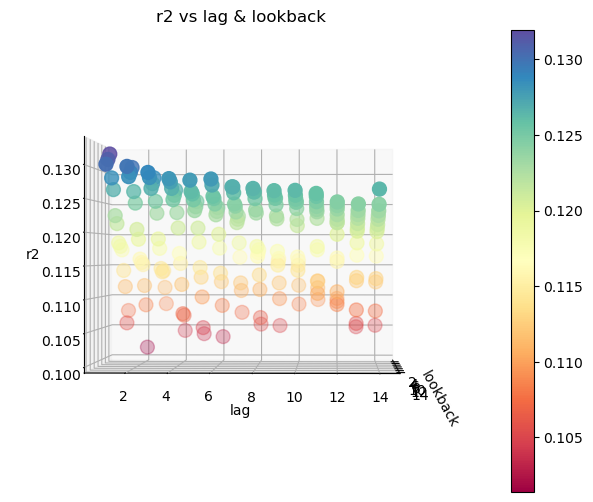

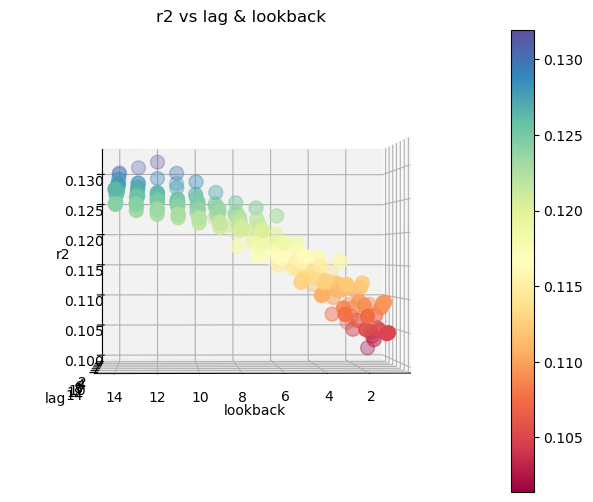

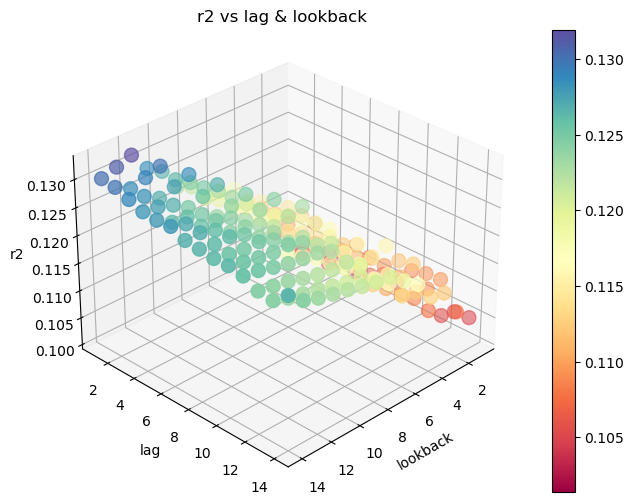

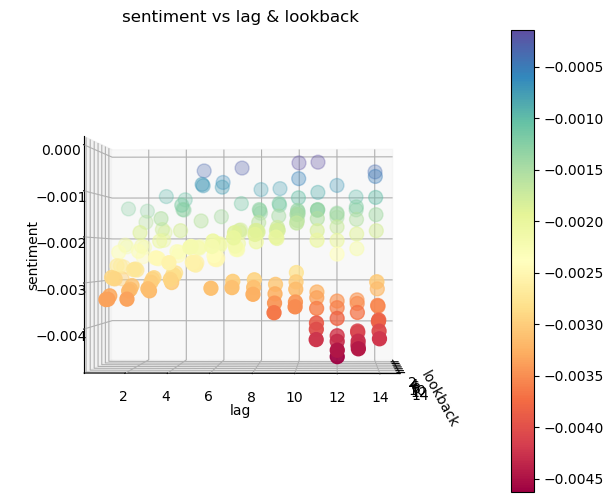

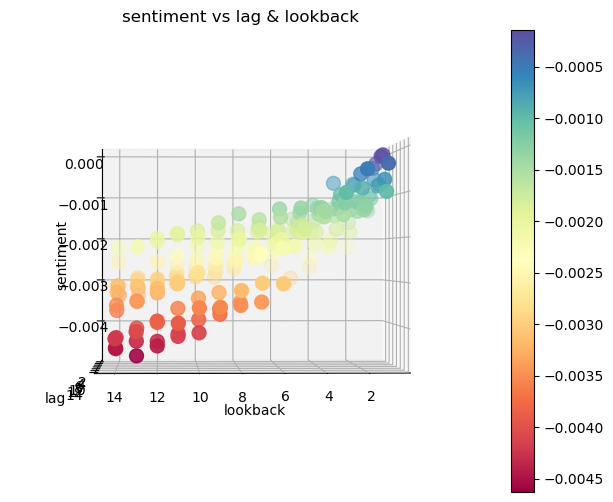

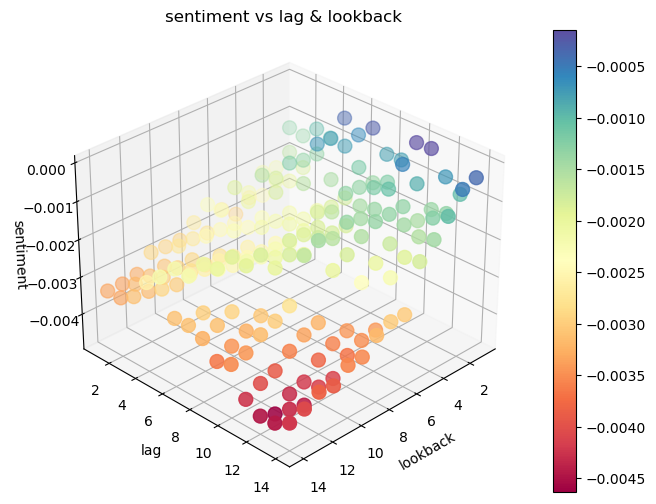

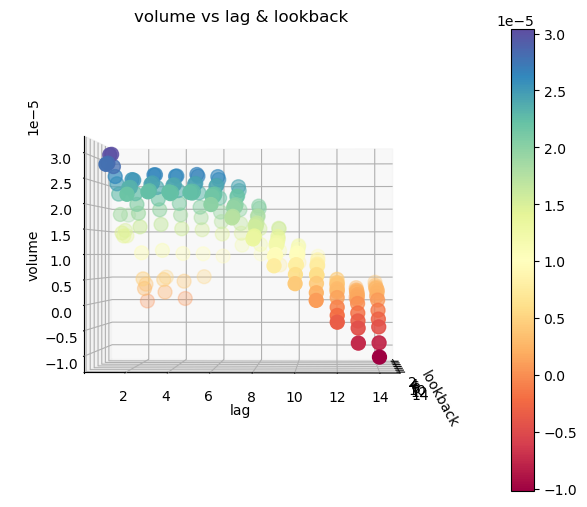

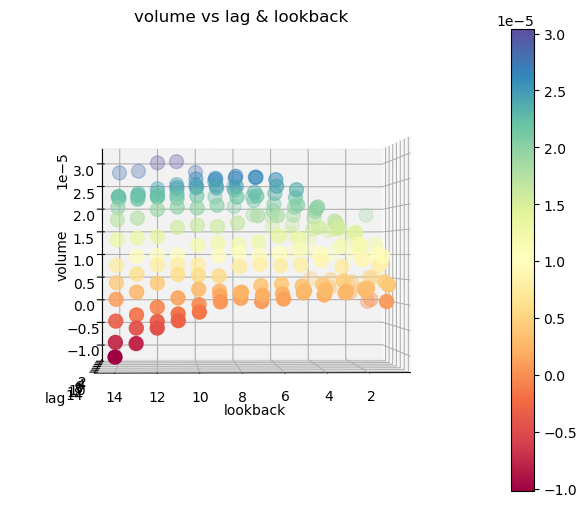

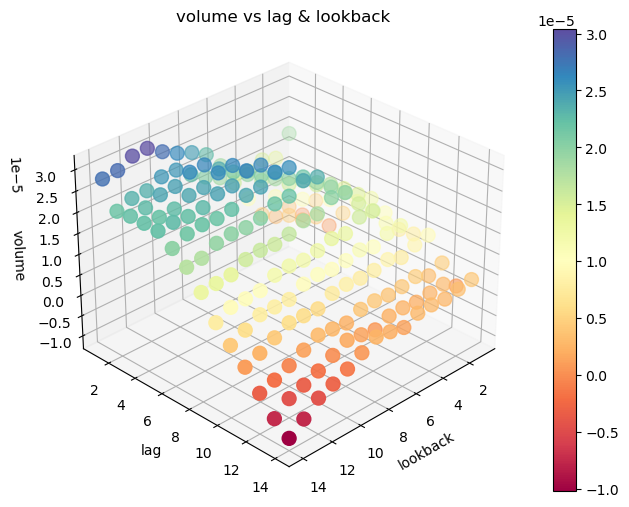

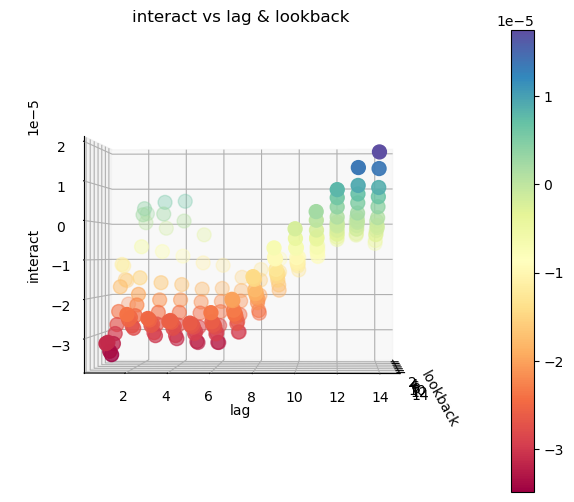

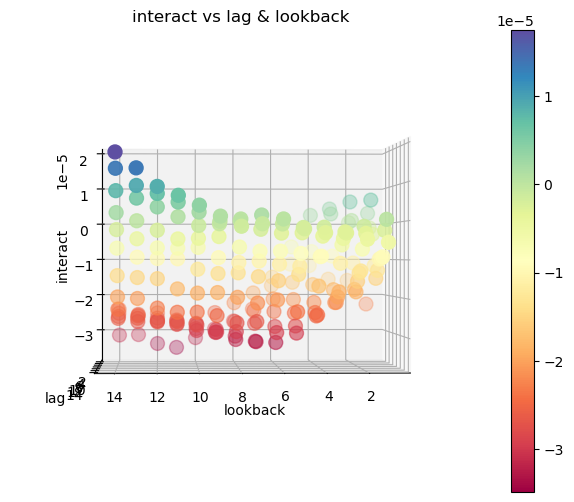

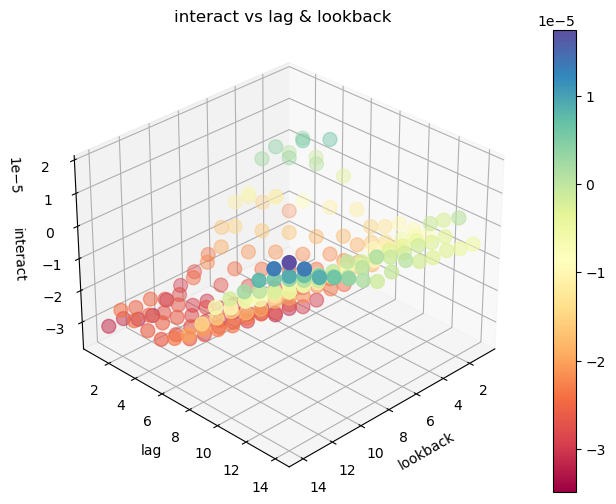

In [54]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitvader.csv"
all_sides(csv_path, 'r2')
all_sides(csv_path, 'sentiment')
all_sides(csv_path, 'volume')
all_sides(csv_path, 'interact')


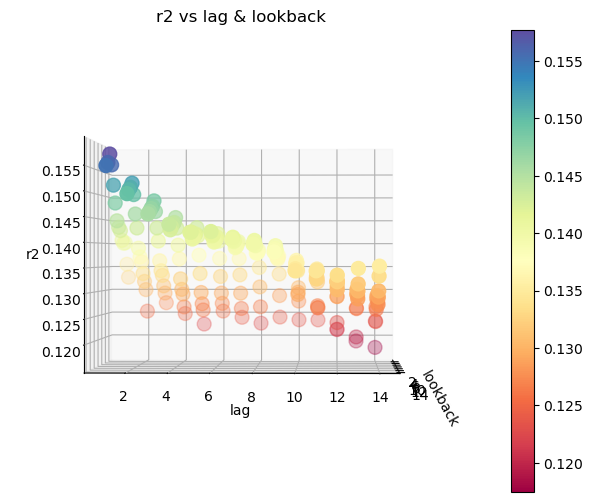

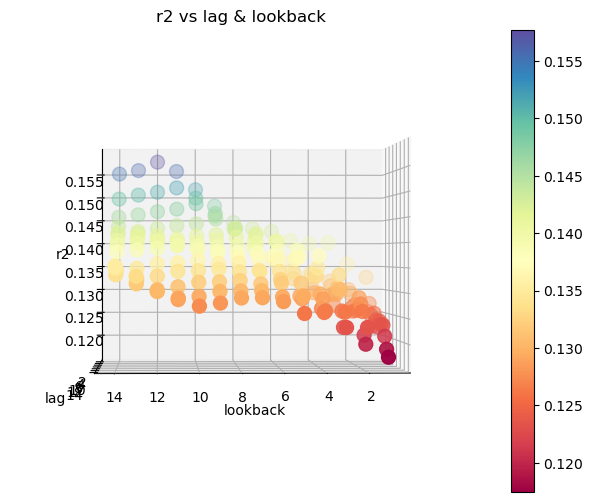

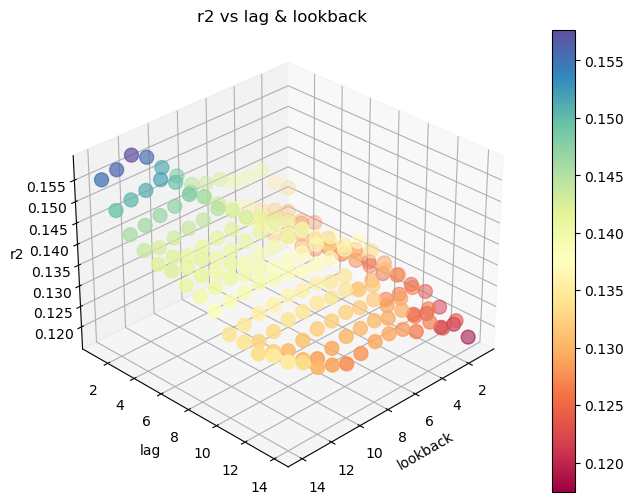

In [20]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitfinbert.csv"
all_sides(csv_path, 'r2')

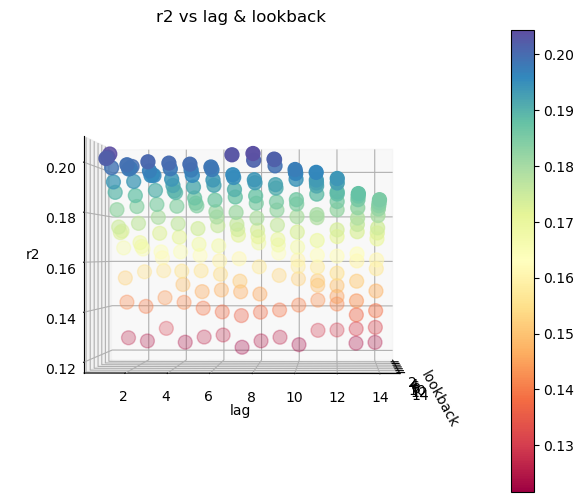

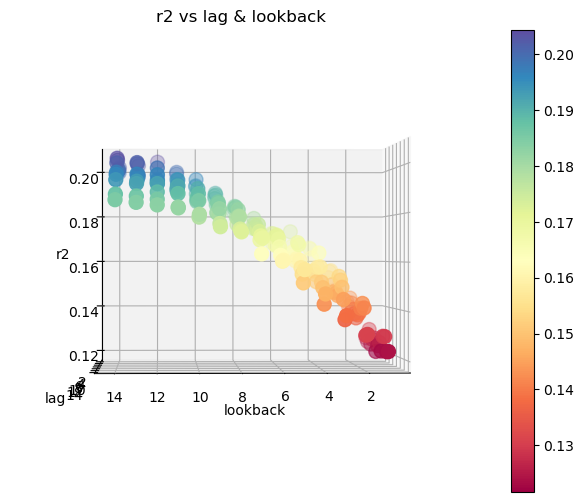

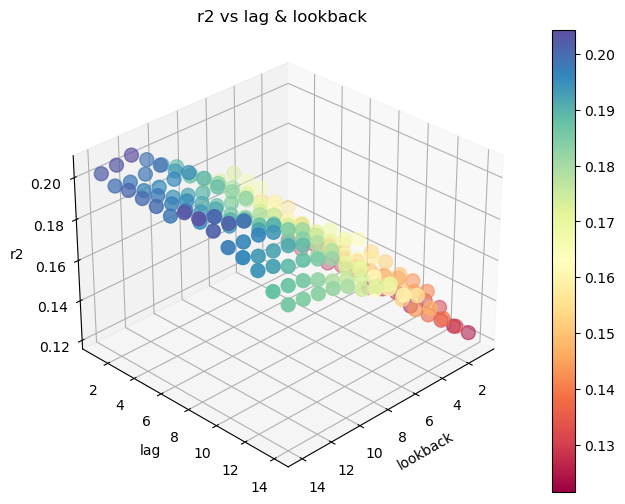

In [21]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redvader.csv"
all_sides(csv_path, 'r2')

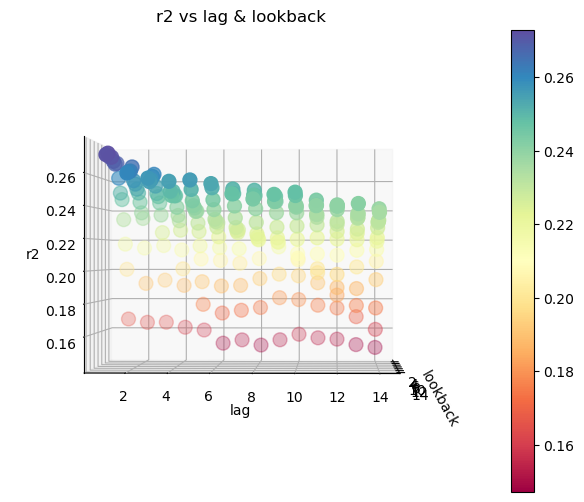

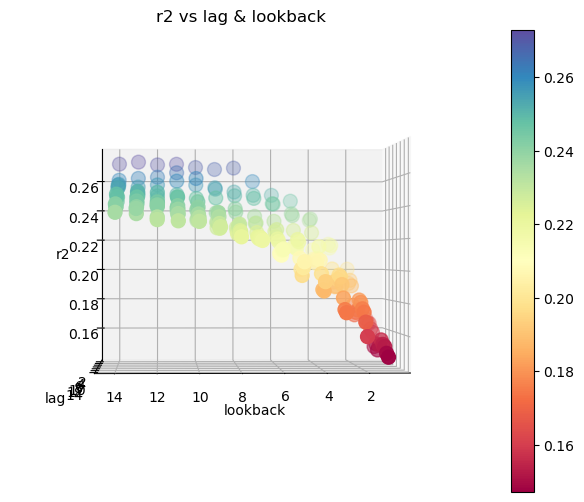

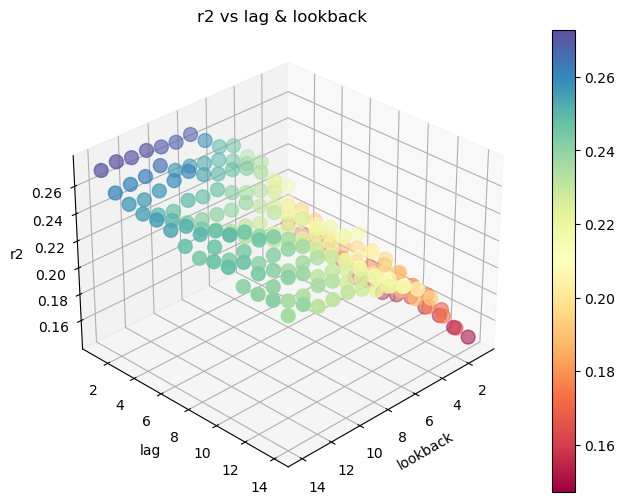

In [22]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redfinbert.csv"
all_sides(csv_path, 'r2')

### Post limit <a class="anchor" id="sub-bullet2.4"></a>

[Go back up](#top)

In [81]:
def grab_coefficients(df_input, stata_code, stata_code2, limit, lag=1, rolling=1):
    Stata.run(df_input, stata_code)
    print("Now running 'grab_coefficients'")

    r = stata.get_return()
    coefficients = r['r(PT)']
    
    # STATA has a small brain so in order to retrieve r2 different code needs to be ran
    Stata.run(df_input, stata_code2)
    e = stata.get_ereturn()
    
    # Coefficients
    pos = 0
    sentiment = coefficients[0][pos]
    volume = coefficients[1][pos]
    interact = coefficients[2][pos]
    marketcap_control = coefficients[3][pos]
    stockprice_control = coefficients[4][pos]
    r2 = e['e(r2)']
    obs_left = e['e(N)']
    
    # p-values
    pos = 3
    sentiment_p = coefficients[0][pos]
    volume_p = coefficients[1][pos]
    interact_p = coefficients[2][pos]
    marketcap_control_p = coefficients[3][pos]
    stockprice_control_p = coefficients[4][pos]

    result = [limit, obs_left, sentiment, volume, interact, marketcap_control, stockprice_control, r2, sentiment_p, volume_p, interact_p, marketcap_control_p, stockprice_control_p]
    print(f"Now returning coefficients: {result}")
    return result

def regression(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, limit, lag=1, rolling=1):
    print("Now running 'regression'")
    df_input = df.copy()

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Filtering observations with less than required daily post volume
    df_input = df_input[df_input[volume_col] > limit]

    result = grab_coefficients(df_input, stata_code, stata_code2, limit, lag, rolling)
    
    return result

def repeat_reg(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, post_limit_range, lag=1, rolling=1):
    print("Now running 'repeat_reg'")
    # Creating empty df
    result_df = pd.DataFrame(columns=['limit', 'obs_left', 'sentiment', 'volume', 'interact', 'marketcap_control', 'stockprice_control', 'r2', 'sentiment_p', 'volume_p', 'interact_p', 'marketcap_control_p', 'stockprice_control_p'])
    # create a list of dataframes to concatenate
    results = []
    
    # Loops all options from 0 until post_limit_range - 1
    for limit in range(post_limit_range):
        
        print(f"Now doing regression with lag [{lag}] and rolling {rolling}")

        result = regression(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, limit=limit)
        results.append(pd.DataFrame([result], columns=result_df.columns))
        print("Saved results to list")
        

    # concatenate the dataframes
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df
    

**Twitter**

In [ ]:
# Calculating lag-rol combinations for Twitter - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\limit_twitvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, post_limit_range=501)

    result_df.to_csv(save_path)


#### Graphs <a class="anchor" id="sub-bullet2.4.1"></a>


In [133]:
def plot_graph(df, y1, y2='[taq]price', x='date', x_label="", y1_label="", y2_label="", debug=False):

    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    # Colours    
    colour_dict = {
    'colour_1': "#1f77b4",
    'colour_2': "#ff7f0e",
    'colour_3': "#2ca02c",
    'colour_4': "#d62728",
    'colour_5': "#9467bd",
    'colour_6': "#8c564b",
    'colour_7': "#e377c2"
    }
    
    ax1.plot(df[x], df[y1], label=y1_label, color=colour_dict['colour_1'], lw=2.5) 


            
    
    # General graph setup
    if len(y2) > 0:
        ax2 = ax1.twinx()
        ax2.plot(df[x], df[y2], label=y2_label, color=colour_dict['colour_2'], lw=2.5)
        ax2.set_ylabel(''.join(y2), fontsize=14)
        ax2.tick_params(axis="y")
        ax2.legend(loc = "upper right")
     
    
    ax1.set_xlabel(x_label, fontsize=14)
    ax1.set_ylabel(y1_label, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()
    

    
    ax1.legend(loc = "upper left")
    fig.suptitle(f"{y1_label} and {y2_label} vs {x}", fontsize=20)
    
    fig.autofmt_xdate()
    plt.show()




In [14]:
df = pd.read_csv(r"E:\Users\Christiaan\Large_Files\Thesis\results\limit_twitvader.csv")

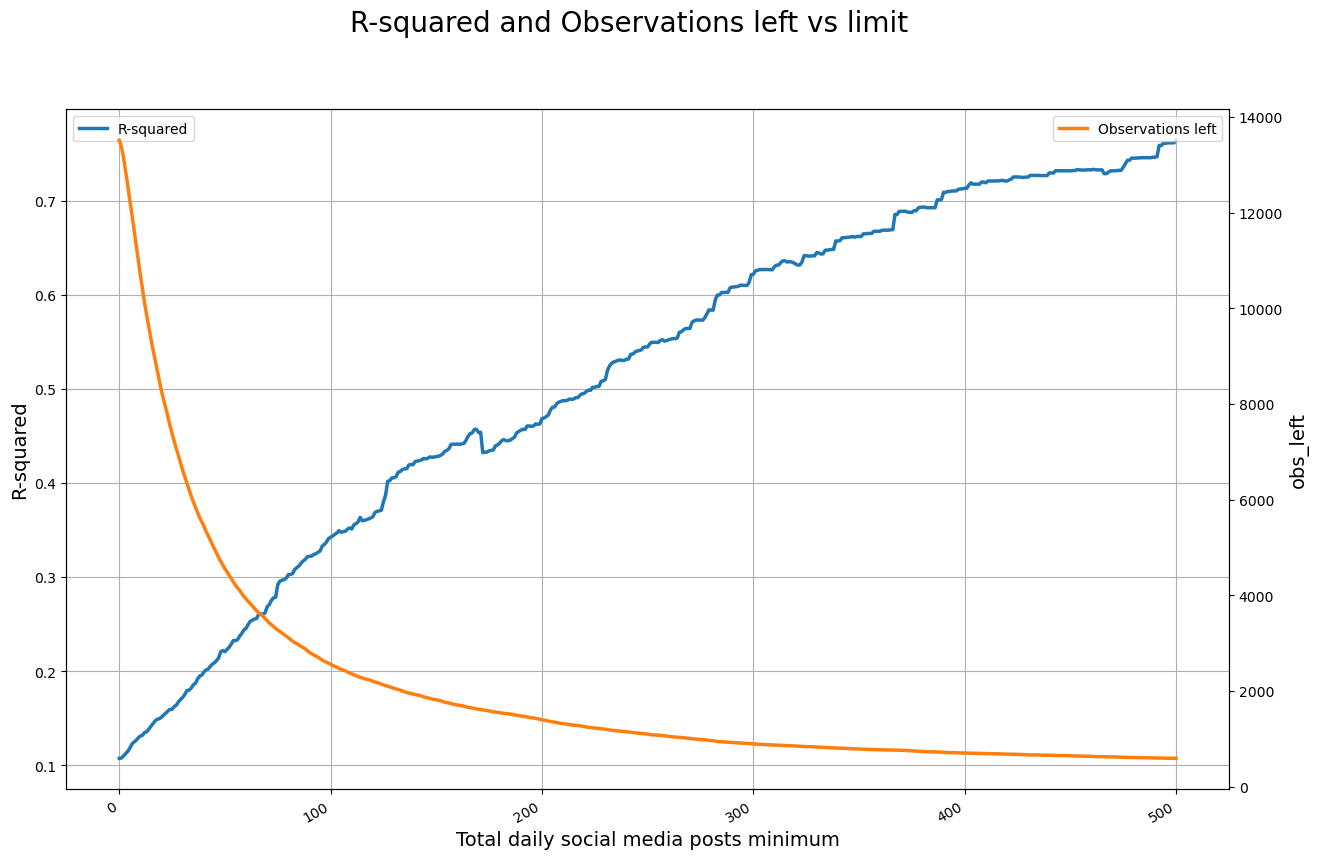

In [106]:
plot_graph(df, y1='r2', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="R-squared", y2_label="Observations left", debug=False)

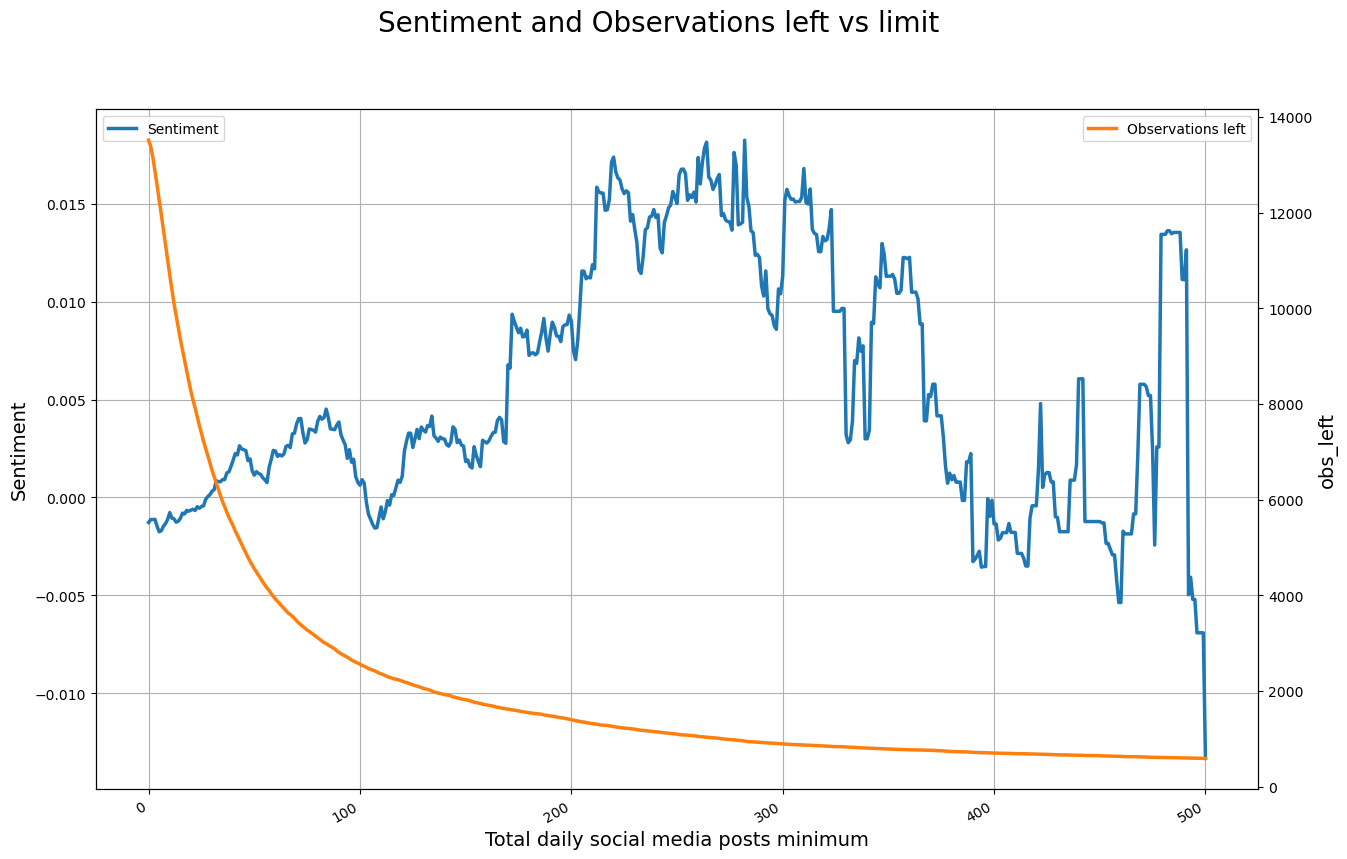

In [109]:
plot_graph(df, y1='sentiment', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="Sentiment", y2_label="Observations left", debug=False)

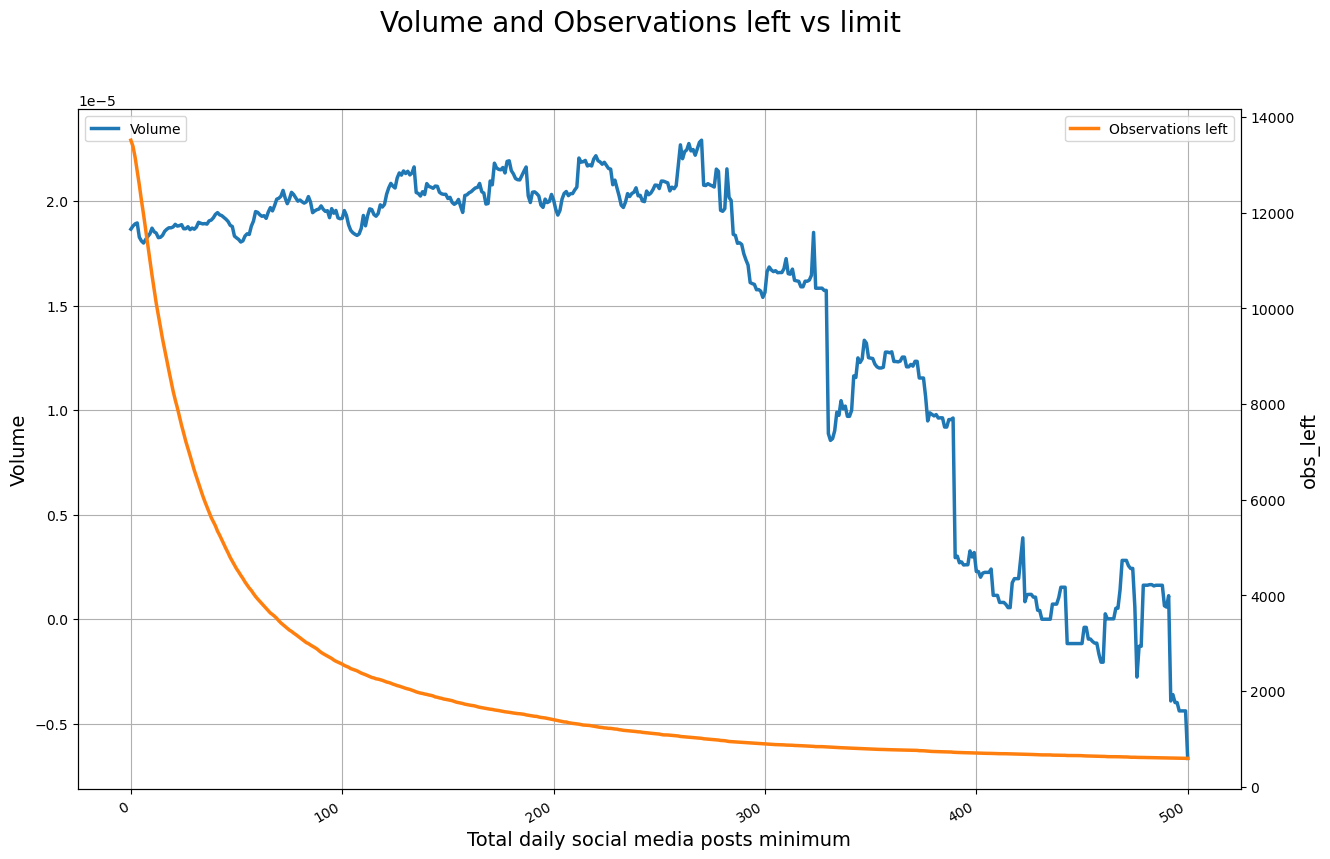

In [115]:
plot_graph(df, y1='volume', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="Volume", y2_label="Observations left", debug=False)

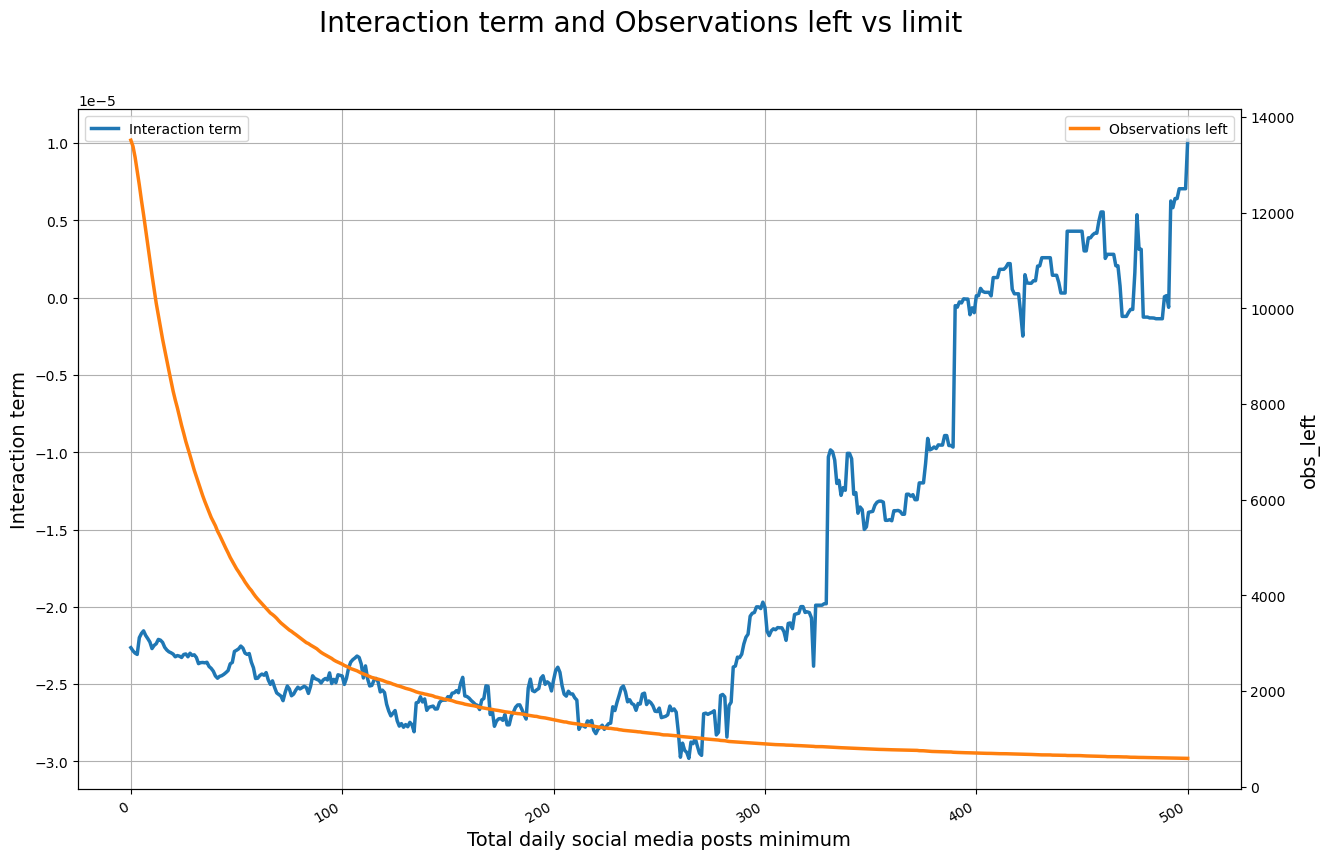

In [19]:
plot_graph(df, y1='interact', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="Interaction term", y2_label="Observations left", debug=False)

In [ ]:
run = False
if run:
    my_bins = [x for x in range(5, 501, 5)]
    my_data = df['[twit][f2s2]total']

    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.hist(my_data, bins=my_bins, edgecolor='k')
    ax = fig.add_subplot(212)
    h,e = np.histogram(my_data, bins=my_bins)
    ax.bar(range(len(my_bins)-1),h, width=1, edgecolor='k')
    ax.set_xticks(range(len(my_bins)-1))
    ax.set_xticklabels(my_bins[:-1])

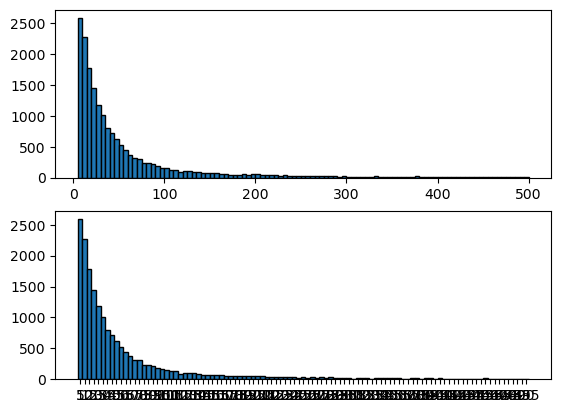

To get more in depth regression results, regressions are rerun for a few seperate data points

#### Regressions <a class="anchor" id="sub-bullet2.4.2"></a>

[Go back up](#top)

In [ ]:
def run_twitvader(threshold=0, lag=1, rolling=1):
    custom_code = """
    reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [33]:
run_twitvader(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =     13,517
                                                F(586, 12929)     =          .
            

      21497  |   .0009655   .0036811     0.26   0.793                 .0037119
      21500  |   .0005796   .0033239     0.17   0.862                 .0021816
      21501  |  -.0010934    .003204    -0.34   0.733                -.0042039
      21502  |  -.0022345   .0032393    -0.69   0.490                -.0085908
      21503  |  -.0012971    .003538    -0.37   0.714                -.0049868
      21504  |  -.0008362   .0036095    -0.23   0.817                 -.003215
      21507  |  -.0017752    .003235    -0.55   0.583                -.0068252
      21508  |  -.0036576   .0032211    -1.14   0.256                -.0140621
      21509  |   .0000976   .0032342     0.03   0.976                 .0003752
      21511  |  -.0015319   .0032153    -0.48   0.634                -.0058897
      21514  |  -.0023195   .0033056    -0.70   0.483                -.0091012
      21515  |  -.0035682   .0032218    -1.11   0.268                -.0140008
      21516  |  -.0022532   .0032024    -0.70   0.48

      21731  |  -.0026405    .003199    -0.83   0.409                -.0101517
      21732  |  -.0028767   .0031595    -0.91   0.363                -.0110598
      21733  |  -.0023274   .0031889    -0.73   0.465                -.0089483
      21735  |  -.0015042   .0031665    -0.48   0.635                -.0056616
      21738  |   -.001827   .0031916    -0.57   0.567                -.0067257
      21739  |   -.002075   .0032775    -0.63   0.527                  -.00781
      21740  |  -.0021157   .0032674    -0.65   0.517                -.0079632
      21741  |  -.0026197   .0032205    -0.81   0.416                -.0098601
      21742  |  -.0002466   .0033406    -0.07   0.941                -.0009676
      21745  |  -.0004143   .0032774    -0.13   0.899                -.0016258
      21746  |  -.0008308   .0032338    -0.26   0.797                -.0031941
      21747  |   .0000518   .0041745     0.01   0.990                 .0002031
      21748  |   -.000161   .0038349    -0.04   0.96

      21920  |  -.0024001   .0031409    -0.76   0.445                -.0094177
      21930  |   .0099227   .0062687     1.58   0.113                 .0389346
      21931  |  -.0023814   .0033144    -0.72   0.472                -.0093441
      21935  |   .0009881   .0038399     0.26   0.797                  .003877
      21936  |  -.0011546    .003572    -0.32   0.747                -.0045305
      21937  |  -.0034781   .0033003    -1.05   0.292                -.0136475
      21938  |  -.0034779   .0032705    -1.06   0.288                -.0133715
      21941  |  -.0048296   .0032201    -1.50   0.134                -.0177789
      21942  |   .0017609   .0033572     0.52   0.600                 .0067701
      21943  |  -.0030848   .0033563    -0.92   0.358                  -.01186
      21944  |  -.0047606   .0035541    -1.34   0.180                -.0183029
      21945  |  -.0029373   .0034343    -0.86   0.392                -.0115254
      21948  |   .0005498   .0051206     0.11   0.91

      22089  |   .0026386   .0036479     0.72   0.469                 .0103532
      22090  |  -.0006714   .0033802    -0.20   0.843                -.0025814
      22091  |  -.0020966   .0032084    -0.65   0.513                -.0082268
      22092  |  -.0028349   .0032527    -0.87   0.383                -.0108993
      22095  |  -.0005531   .0036277    -0.15   0.879                -.0021702
      22096  |   .0016655   .0038526     0.43   0.666                 .0065352
      22097  |   .0023627   .0036018     0.66   0.512                 .0092709
      22098  |   .0021862    .004044     0.54   0.589                 .0085783
      22102  |   .0065106   .0053732     1.21   0.226                 .0250311
      22103  |    .004994   .0039163     1.28   0.202                 .0195954
      22104  |   .0038151   .0041759     0.91   0.361                 .0149696
      22105  |    .004209   .0037384     1.13   0.260                 .0165152
      22106  |   .0027502   .0042819     0.64   0.52

In [28]:
run_twitvader(threshold=10)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =     10,697
                                                F(586, 10109)     =          .
            

      21643  |  -.0012339   .0050004    -0.25   0.805                 -.004964
      21644  |  -.0036338   .0035557    -1.02   0.307                -.0142981
      21647  |   .0012219   .0040156     0.30   0.761                 .0035524
      21648  |  -.0020311   .0033728    -0.60   0.547                -.0076206
      21649  |  -.0033229   .0033534    -0.99   0.322                 -.013075
      21650  |   -.002237   .0035323    -0.63   0.527                -.0083934
      21651  |  -.0019272   .0039515    -0.49   0.626                -.0075833
      21654  |   .0006659   .0042162     0.16   0.875                 .0019361
      21655  |  -.0035972   .0036381    -0.99   0.323                -.0128052
      21656  |  -.0042129   .0034056    -1.24   0.216                -.0165768
      21657  |  -.0037447   .0033818    -1.11   0.268                -.0140501
      21661  |    -.00263   .0047871    -0.55   0.583                -.0073211
      21662  |  -.0017158   .0035824    -0.48   0.63

      21916  |   .0009096   .0037329     0.24   0.807                  .002532
      21917  |  -.0025219   .0033885    -0.74   0.457                 -.009923
      21920  |  -.0026165   .0033103    -0.79   0.429                -.0079175
      21930  |   .0121257   .0067463     1.80   0.072                 .0466168
      21931  |  -.0025935    .003529    -0.73   0.462                -.0099707
      21935  |   .0021684   .0044407     0.49   0.625                  .007719
      21936  |  -.0010625   .0038773    -0.27   0.784                -.0040849
      21937  |  -.0040459   .0034988    -1.16   0.248                -.0159195
      21938  |  -.0039459   .0034503    -1.14   0.253                -.0148051
      21941  |   -.004122   .0034535    -1.19   0.233                -.0119841
      21942  |   .0017052   .0036808     0.46   0.643                   .00607
      21943  |  -.0034818   .0035382    -0.98   0.325                -.0133856
      21944  |  -.0054413   .0039592    -1.37   0.16


. 
.     
. 


In [29]:
run_twitvader(threshold=50)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =      4,558
                                                F(575, 3970)      =          .
            

      21411  |   .0063671   .0039424     1.62   0.106                 .0206526
      21412  |   .0076979   .0054613     1.41   0.159                 .0236904
      21413  |   .0014827   .0043015     0.34   0.730                 .0050435
      21416  |   .0116582   .0091347     1.28   0.202                 .0239321
      21417  |   .0032466   .0056171     0.58   0.563                 .0105309
      21418  |   -.000332   .0049805    -0.07   0.947                 -.001077
      21419  |  -.0011349   .0060435    -0.19   0.851                -.0030808
      21420  |   .0040615   .0066226     0.61   0.540                 .0110258
      21423  |   .0101151   .0112215     0.90   0.367                 .0207644
      21424  |  -.0022805   .0042118    -0.54   0.588                -.0070182
      21425  |   .0038241   .0097643     0.39   0.695                 .0124041
      21426  |   .0046961   .0041259     1.14   0.255                 .0144524
      21427  |  -.0016203   .0070183    -0.23   0.81

      21648  |  -.0014438   .0026381    -0.55   0.584                -.0044433
      21649  |  -.0012813   .0026578    -0.48   0.630                -.0034783
      21650  |   .0023811   .0035115     0.68   0.498                 .0069097
      21651  |   .0032439   .0055063     0.59   0.556                 .0099831
      21654  |   .0110778   .0074824     1.48   0.139                 .0196962
      21655  |  -.0029612   .0043867    -0.68   0.500                -.0085929
      21656  |  -.0042854   .0030783    -1.39   0.164                -.0124357
      21657  |  -.0034995   .0030704    -1.14   0.254                -.0101551
      21661  |   .0141936   .0079404     1.79   0.074                 .0206074
      21662  |  -.0002582   .0034581    -0.07   0.940                -.0007492
      21663  |   .0014188   .0041671     0.34   0.734                 .0048262
      21664  |   .0052109   .0057984     0.90   0.369                 .0177253
      21665  |  -.0012781    .003984    -0.32   0.74

      21838  |  -.0017538   .0027755    -0.63   0.528                 -.004761
      21839  |  -.0033116   .0027512    -1.20   0.229                -.0107416
      21840  |  -.0000804   .0026858    -0.03   0.976                -.0002182
      21843  |   .0061869   .0071841     0.86   0.389                 .0141981
      21844  |   .0022971   .0030216     0.76   0.447                 .0070694
      21845  |  -.0033429   .0049364    -0.68   0.498                -.0108433
      21846  |  -.0070584    .008979    -0.79   0.432                -.0217224
      21847  |  -.0061926    .003347    -1.85   0.064                -.0219991
      21850  |  -.0042518   .0048202    -0.88   0.378                -.0097574
      21851  |  -.0046353   .0040694    -1.14   0.255                -.0125836
      21852  |  -.0046185    .002993    -1.54   0.123                -.0149809
      21853  |  -.0045359   .0027298    -1.66   0.097                -.0139593
      21854  |  -.0035939   .0029099    -1.24   0.21

      22020  |   .0022414   .0045893     0.49   0.625                 .0088992
      22021  |   .0069443   .0068786     1.01   0.313                 .0236215
      22022  |   .0016961   .0027502     0.62   0.537                 .0060252
      22025  |   .0105716   .0057935     1.82   0.068                 .0286991
      22026  |   .0066979   .0040936     1.64   0.102                 .0227835
      22027  |   .0008103   .0043439     0.19   0.852                 .0028785
      22028  |  -.0064016   .0037618    -1.70   0.089                -.0197012
      22029  |  -.0033861   .0053645    -0.63   0.528                -.0109834
      22032  |  -.0015906   .0076339    -0.21   0.835                -.0036503
      22033  |   .0045023   .0032337     1.39   0.164                 .0172718
      22034  |  -.0029118   .0038782    -0.75   0.453                 -.011561
      22035  |   .0000224   .0036515     0.01   0.995                 .0000828
      22036  |  -.0031276   .0040458    -0.77   0.44

In [30]:
run_twitvader(threshold=100)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =      2,565
                                                F(497, 1977)      =          .
            

      21507  |  -.0005562   .0035455    -0.16   0.875                -.0006313
      21508  |   .0006968   .0036923     0.19   0.850                 .0019353
      21509  |   .0044577    .003464     1.29   0.198                 .0133715
      21511  |   .0051205   .0032662     1.57   0.117                 .0082181
      21514  |   .0002587   .0035744     0.07   0.942                 .0002937
      21515  |   .0009366   .0037143     0.25   0.801                 .0021249
      21516  |   .0017597   .0035089     0.50   0.616                 .0044628
      21517  |   .0015963   .0035984     0.44   0.657                 .0044338
      21518  |   .0026451   .0039024     0.68   0.498                 .0067083
      21521  |   .0037771   .0063674     0.59   0.553                 .0060619
      21522  |  -.0013745   .0042002    -0.33   0.744                -.0031184
      21524  |   .0036635   .0040716     0.90   0.368                 .0058797
      21525  |   .0046089   .0038595     1.19   0.23

      21720  |  -.0010852   .0047469    -0.23   0.819                -.0030144
      21721  |  -.0013178   .0032164    -0.41   0.682                -.0029899
      21724  |   .0039803   .0036094     1.10   0.270                 .0045179
      21725  |   .0014942   .0034932     0.43   0.669                  .001696
      21726  |   .0045482   .0040441     1.12   0.261                 .0115348
      21727  |  -.0012989   .0035742    -0.36   0.716                -.0032941
      21728  |  -.0014041   .0045474    -0.31   0.758                -.0031856
      21731  |   .0009448   .0034874     0.27   0.786                 .0010724
      21732  |  -.0011609   .0041071    -0.28   0.777                -.0022815
      21733  |  -.0018776   .0033561    -0.56   0.576                  -.00426
      21735  |   .0062824   .0034136     1.84   0.066                 .0071311
      21738  |   .0077255   .0036076     2.14   0.032                  .008769
      21739  |  -.0013343   .0041327    -0.32   0.74

      21896  |   .0035563   .0045225     0.79   0.432                 .0098782
      21899  |  -.0142787   .0034263    -4.17   0.000                -.0162074
      21900  |  -.0002394   .0036227    -0.07   0.947                -.0005432
      21901  |  -.0020861   .0038115    -0.55   0.584                -.0052906
      21902  |  -.0006453   .0033823    -0.19   0.849                -.0019357
      21903  |  -.0006148   .0033586    -0.18   0.855                -.0017078
      21906  |   .0053254   .0033997     1.57   0.117                 .0060448
      21907  |  -.0021268   .0035796    -0.59   0.552                -.0048254
      21909  |    .013204   .0033351     3.96   0.000                 .0149875
      21910  |   .0007101   .0036536     0.19   0.846                 .0019725
      21913  |   -.001559   .0034336    -0.45   0.650                -.0017696
      21914  |   .0012032   .0031702     0.38   0.704                 .0027298
      21916  |    .009781   .0035145     2.78   0.00


. 
.     
. 


In [31]:
run_twitvader(threshold=250)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =      1,103
                                                F(338, 523)       =          .
            

      21500  |   .0026827   .0044417     0.60   0.546                 .0040514
      21501  |    .005712   .0055819     1.02   0.307                 .0149276
      21502  |   .0055366   .0051738     1.07   0.285                 .0167001
      21503  |   .0051766   .0063302     0.82   0.414                 .0135285
      21504  |   .0117526   .0131515     0.89   0.372                 .0354493
      21507  |  -.0014336    .004405    -0.33   0.745                 -.002165
      21508  |   .0021416   .0061126     0.35   0.726                 .0055968
      21509  |   .0068553   .0053762     1.28   0.203                 .0206777
      21511  |   .0065668   .0046163     1.42   0.155                 .0099172
      21514  |   .0010919   .0045501     0.24   0.810                 .0016489
      21515  |   .0010138   .0054236     0.19   0.852                 .0021642
      21516  |   .0030148   .0056295     0.54   0.593                 .0078789
      21517  |   .0029929   .0057243     0.52   0.60

      21725  |   .0043446   .0051472     0.84   0.399                 .0065612
      21726  |   .0041458   .0063344     0.65   0.513                 .0088505
      21727  |  -.0008959    .007735    -0.12   0.908                -.0019125
      21728  |  -.0040526    .009622    -0.42   0.674                 -.010591
      21731  |   .0015402   .0044672     0.34   0.730                  .002326
      21732  |   .0047096   .0049774     0.95   0.344                 .0071124
      21733  |  -.0035497   .0052481    -0.68   0.499                -.0053607
      21735  |   .0062454   .0043551     1.43   0.152                 .0094318
      21738  |   .0075145   .0044517     1.69   0.092                 .0113484
      21739  |   .0043766   .0049105     0.89   0.373                 .0093432
      21740  |  -.0035141   .0074477    -0.47   0.637                -.0075019
      21741  |  -.0001881   .0058887    -0.03   0.975                -.0004016
      21742  |   .0025727    .004584     0.56   0.57

      21970  |  -.0039228   .0080092    -0.49   0.624                -.0083744
      21971  |   .0090624   .0060849     1.49   0.137                 .0236835
      21972  |   -.015025    .006437    -2.33   0.020                -.0392661
      21973  |   .0101718   .0056493     1.80   0.072                 .0217146
      21976  |   .0165272   .0043618     3.79   0.000                 .0249595
      21977  |    .024148   .0108873     2.22   0.027                 .0515509
      21978  |   .0054057   .0083632     0.65   0.518                   .01154
      21979  |  -.0008908     .00462    -0.19   0.847                -.0013453
      21980  |   .0104571   .0044302     2.36   0.019                 .0157924
      21983  |   .0052196   .0043199     1.21   0.227                 .0078827
      21984  |   .0137834   .0064779     2.13   0.034                 .0294247
      21985  |  -.0033281    .004717    -0.71   0.481                -.0071048
      21986  |   .0186135   .0346657     0.54   0.59


. 
.     
. 


In [32]:
run_twitvader(threshold=500)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust
> ) beta

Linear regression                               Number of obs     =        595
                                                F(141, 127)       =          .
            

      21546  |   .0021659   .0014343     1.51   0.134                 .0038632
      21552  |   .0261831   .0206421     1.27   0.207                 .0659897
      21553  |   .0093029   .0250213     0.37   0.711                 .0234463
      21557  |  -.0015348   .0050235    -0.31   0.760                -.0027375
      21558  |  -.0007467     .00148    -0.50   0.615                -.0013319
      21559  |  -.0003854   .0075197    -0.05   0.959                -.0011885
      21560  |   .0051609   .0094781     0.54   0.587                 .0130071
      21565  |   .0050262   .0162523     0.31   0.758                  .008965
      21566  |   .0046637   .0011326     4.12   0.000                 .0083183
      21567  |   .0609106   .0860316     0.71   0.480                 .1535136
      21571  |    .049872   .0019735    25.27   0.000                 .0889532
      21572  |   .0290594   .0040026     7.26   0.000                 .0518313
      21579  |   .0171769   .0357164     0.48   0.63

      21973  |   .0259788   .0133135     1.95   0.053                 .0463366
      21977  |   .0315242   .0101291     3.11   0.002                 .0562275
      21978  |    .013844   .0054808     2.53   0.013                 .0246926
      21979  |     .00662   .0038858     1.70   0.091                 .0118077
      21980  |   .0174326   .0035424     4.92   0.000                 .0310934
      21984  |   .0296699   .0111463     2.66   0.009                 .0529203
      21985  |   .0019338   .0017505     1.10   0.271                 .0034492
      21986  |   .0147674   .0387578     0.38   0.704                 .0372185
      21987  |   .0406492   .0229269     1.77   0.079                 .1024487
      21991  |   .0176385   .0233779     0.75   0.452                 .0444546
      21992  |   .0820765   .0632692     1.30   0.197                 .2068585
      21993  |   .0498733   .0226364     2.20   0.029                 .1256964
      21994  |   .0411378   .0278029     1.48   0.14

### Market cap <a class="anchor" id="sub-bullet2.5"></a>

[Go back up](#top)

Both market cap and post limit can affect the regression results.

In [39]:
def grab_coefficients(df_input, stata_code, ticker, lag, rolling, marketcaps, marketcaps_rank, average_daily_posts):
    Stata.run(df_input, stata_code)
    print("Now running 'grab_coefficients'")

    r = stata.get_return()
    coefficients = r['r(PT)']
    
    e = stata.get_ereturn()
    
    # Coefficients
    pos = 0
    sentiment = coefficients[0][pos]
    volume = coefficients[1][pos]
    interact = coefficients[2][pos]
    marketcap_control = coefficients[3][pos]
    stockprice_control = coefficients[4][pos]
    r2 = e['e(r2)']
    
    # p-values
    pos = 3
    sentiment_p = coefficients[0][pos]
    volume_p = coefficients[1][pos]
    interact_p = coefficients[2][pos]
    marketcap_control_p = coefficients[3][pos]
    stockprice_control_p = coefficients[4][pos]
    
    result = [ticker, marketcaps[ticker], marketcaps_rank[ticker], average_daily_posts[ticker], sentiment, volume, interact, marketcap_control, stockprice_control, r2, sentiment_p, volume_p, interact_p, marketcap_control_p, stockprice_control_p]
    print(f"Now returning coefficients: {result}")
    return result

def regression(stata_code, df, ticker, lag, rolling, sentiment_col, volume_col, interaction_col, marketcaps, marketcaps_rank, average_daily_posts):
    print("Now running 'regression'")
    df_input = df.copy()

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)

    result = grab_coefficients(df_input, stata_code, ticker, lag, rolling, marketcaps, marketcaps_rank, average_daily_posts)
    
    return result

def repeat_reg(stata_code, df, sentiment_col, volume_col, interaction_col, lag=1, rolling=1):
    print("Now running 'repeat_reg'")
    # Creating empty df
    result_df = pd.DataFrame(columns=['ticker', 'marketcap', 'marketcap_rank', 'daily_posts', 'sentiment', 'volume', 'interact', 'marketcap_control', 'stockprice_control', 'r2', 'sentiment_p', 'volume_p', 'interact_p', 'marketcap_control_p', 'stockprice_control_p'])
    # create a list of dataframes to concatenate
    results = []
    
    ticker_list = ['AAPL', 'AMD', 'AMZN', 'ATVI', 'BA', 'BABA', 'BAC', 'DIS', 'F', 'GE', 'GME', 'IQ', 'LULU', 'MSFT', 'MU', 'NFLX', 'NVDA', 'SBUX', 'SHOP', 'SNAP', 'SQ', 'TLRY', 'TSLA', 'V', 'WMT']
    # Marketcap info
    marketcaps = df.groupby('[rh]ticker').mean()['[crsp]mrktcap']
    marketcaps_rank = df.groupby('[rh]ticker').mean()['[crsp]mrktcap'].rank()
    average_daily_posts = df.groupby('[rh]ticker').mean()['[twit][f2s2]total']
    
    for ticker in ticker_list:
        df_input = df[df['[rh]ticker'] == ticker].copy()
        
        result = regression(stata_code, df_input, ticker, lag, rolling, sentiment_col, volume_col, interaction_col, marketcaps, marketcaps_rank, average_daily_posts)
        results.append(pd.DataFrame([result], columns=result_df.columns))
        print("Saved results to list")
        
    
                   
    # concatenate the dataframes
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df
    

**Twitter**

In [35]:
def show_scatter(csv_path, x, y, annotate=True):
    df = pd.read_csv(csv_path)

    # Create the scatter plot
    ax = df.plot.scatter(x=x, y=y)

    # Add labels to the scatter plot
    if annotate:
        for i, row in df.iterrows():
            ax.annotate(row['ticker'], (row[x] + 0.3, row[y]))

    # Show the plot
    plt.show()


In [ ]:
# Calculating marketcap results for Twitter - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust)
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, df_input, sentiment_col, volume_col, interaction_col, lag=1, rolling=1)

    result_df.to_csv(save_path, index=False)


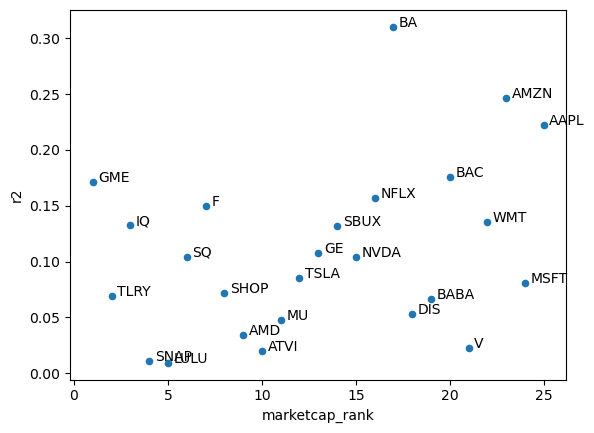

In [112]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitvader.csv"
show_scatter(csv_path, x='marketcap_rank', y='r2')

In [ ]:
# Calculating marketcap results for Twitter - finBERT
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitfinbert.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control, vce(robust)
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2BERT]method_1'
    volume_col = '[twit][f2BERT]total'
    interaction_col = '[f2BERT]interact_sent_vol'
    
    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, df_input, sentiment_col, volume_col, interaction_col, lag=1, rolling=1)

    result_df.to_csv(save_path, index=False)


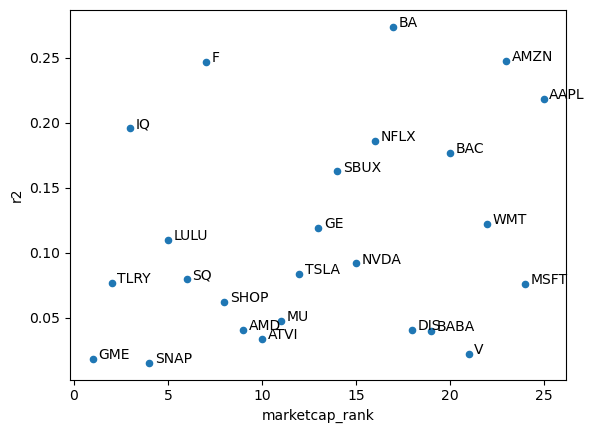

In [49]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitfinbert.csv"
show_scatter(csv_path, x='marketcap_rank', y='r2')

In [ ]:
# Calculating marketcap results for Reddit - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_redvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust)
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2s2]method_1'
    volume_col = '[red][m2f2s2]total'
    interaction_col = '[m2f2s2]interact_sent_vol'
    
    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, df_input, sentiment_col, volume_col, interaction_col, lag=1, rolling=1)

    result_df.to_csv(save_path, index=False)


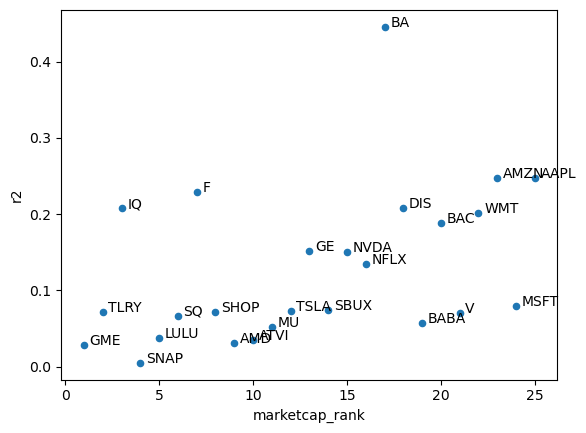

In [46]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_redvader.csv"
show_scatter(csv_path, x='marketcap_rank', y='r2')

In [89]:
datalist = [[-1.12170673e-03,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [123,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [456,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03]]
r['r(table)'][0]
r['r(table)'][3]
import pandas as pd

# create an empty dataframe
df = pd.DataFrame(columns=['value_1', 'value_2', 'value_3', 'value_4', 'value_5'])

# create a list of dataframes to concatenate
dfs = []
for data in datalist:
    dfs.append(pd.DataFrame([data], columns=df.columns))

# concatenate the dataframes
df = pd.concat(dfs, ignore_index=True)
df

,value_1,value_2,value_3,value_4,value_5
0,-0.001122,0.00001,-0.000012,1.182742e-12,0.001747
1,123.000000,0.00001,-0.000012,1.182742e-12,0.001747
2,456.000000,0.00001,-0.000012,1.182742e-12,0.001747


In [104]:
stata_code = """regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap"""
# run(df, stata_code)
Stata.run(df, stata_code)

. regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap

      Source |       SS           df       MS      Number of obs   =       561
-------------+----------------------------------   F(4, 556)       =     34.17
       Model |  .004987974         4  .001246994   Prob > F        =    0.0000
    Residual |  .020291878       556  .000036496   R-squared       =    0.1973
-------------+----------------------------------   Adj R-squared   =    0.1915
       Total |  .025279853       560  .000045143   Root MSE        =    .00604

------------------------------------------------------------------------------
rhperforma~1 | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
twitf2s2me~1 |   .0054165   .0034884     1.55   0.121    -.0014356    .0122687
twitf2s2to~l |   .0000104   6.30e-06     1.65   0.101    -2.01e-06    .0000228
f2s2intera~l |  -.0000138   9.36e-0

In [103]:
import os
os.chdir("C:/Program Files/Stata17/utilities")
from pystata import config
config.init("mp")

from pystata import stata

# # Setup Stata
# import stata_setup
# stata_setup.config("C:/Program Files/Stata17", "mp")

# from pystata import stata
# # stata.config.status()




## Vault

[Go back up](#top)

In [56]:
def add_marketcap(results_df, ticker):
    # Path
    csv_path = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments\Thesis\market_cap_info.csv"
    
    # Read csv
    df = pd.read_csv(csv_path)
    
    # Rename twitter columns to contain [crsp]
    df.rename(columns={"Ticker": "ticker", "DlyCalDt": "date", "DlyCap": "[crsp]mrktcap"}, inplace=True)
    
    # Filter observations for ticker
    df = df[df['ticker'] == ticker].reset_index(drop=True)
    
    # Drop ticker column to prevent duplicate
    df.drop(columns=['ticker'], inplace=True)

    # Merge data
    results_df = results_df.merge(df, how='left', left_on='date', right_on='date')

    return results_df


Loop files and add marktcap info

In [58]:
file_dir = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments\Thesis\MERGED_DATA"
ticker_list = ['AAPL', 'AMD', 'AMZN', 'ATVI', 'BA', 'BABA', 'BAC', 'DIS', 'F', 'GE', 'GME', 'IQ', 'LULU', 'MSFT', 'MU', 'NFLX', 'NVDA', 'SBUX', 'SHOP', 'SNAP', 'SQ', 'TLRY', 'TSLA', 'V', 'WMT']

save = False

if save:
    for ticker in ticker_list:
        # file path
        file_path = os.path.join(file_dir, f"{ticker}.csv").replace('\\', '/')

        # Read csv
        merged_df = pd.read_csv(file_path)
        
        # Add files
        df = add_marketcap(merged_df, ticker)


        df.to_csv(file_path, encoding='utf-8', index=False)
        print(f"Merged file saved at: {file_path}")

Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/AAPL.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/AMD.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/AMZN.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/ATVI.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/BA.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/BABA.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/BAC.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/DIS.csv
Merged file saved at: C:/Users/Ck0rt/Document

In [58]:
csv_path = join_paths(working_dir, "Thesis\DATA_MERGED", "AAPL.csv")
df = pd.read_csv(csv_path)

columns = ['[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[crsp]mrktcap']
df[columns] = df[columns].shift(1)
df.dropna(inplace=True)
df['[f2s2]interact_sent_vol'] = df['[twit][f2s2]method_1'] * df['[twit][f2s2]total']
df[['date', '[rh]performance_1', '[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[f2s2]interact_sent_vol', '[crsp]mrktcap']]

,date,[rh]performance_1,[twit][f2s2]method_1,[twit][f2s2]total,[twit][f2s2]rel_vol,[f2s2]interact_sent_vol,[crsp]mrktcap
7,2018-05-08,-0.003110,0.746914,324.0,0.493580,242.0,9.100870e+08
8,2018-05-09,-0.000739,0.607955,176.0,0.395633,107.0,9.144614e+08
9,2018-05-10,0.000816,0.673077,104.0,0.349832,70.0,9.209003e+08
14,2018-05-15,-0.001767,0.666667,87.0,0.657667,58.0,9.247832e+08
15,2018-05-16,-0.000028,0.576923,130.0,1.034091,75.0,9.163783e+08
...,...,...,...,...,...,...,...
828,2020-08-06,0.017180,0.787815,476.0,0.506845,375.0,1.882348e+09
829,2020-08-07,0.012765,0.792222,900.0,1.071064,713.0,1.948022e+09
833,2020-08-11,0.010803,0.654717,530.0,0.959897,347.0,1.927926e+09
834,2020-08-12,0.016233,0.641243,354.0,0.717221,227.0,1.870590e+09


In [21]:
import pystata
import pandas as pd

stata.pdataframe_to_data(get_regression_df(), True)
stata_code = """#regress rhperformance_1 twitf2s2method_1 twitf2s2total crspmrktcap, vce(robust) beta
summarize rhperformance_1 twitf2s2method_1"""

# Run the regression and capture the output in a string
stata.run(stata_code, echo=True)
# regression_output = pystata.run_statamc(stata_code)

# Convert the output to a pandas DataFrame
# regression_results = pd.read_csv(StringIO(regression_output), delim_whitespace=True, skiprows=1)

# Process the regression results here
# r = stata.get_return()['r(table)']
print()
r = stata.get_return()
e = stata.get_ereturn()


. #regress rhperformance_1 twitf2s2method_1 twitf2s2total crspmrktcap, vce(robu
> st) beta
Unknown #command
. summarize rhperformance_1 twitf2s2method_1

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
rhperforma~1 |     13,970    .0014372    .0109256  -.1122662   .2452852
twitf2s2me~1 |     20,617    .6992524    .1845037          0          1

. 



In [108]:
r['r(PT)'][1][0]


6.010338902176173e-06

In [101]:
printed_values

'Hello, world!\n42\n'

In [ ]:
val1 = -.0026394 # coefficients
val2 = .1845037 # stdev indep
val3 = .0109256 # stdev dep

(val1 * val2) / val3

In [109]:
def get_stdev(var):
    var = var.replace('[', '').replace(']', '')
    # Get stdev
    stata_code = """summarize """ + var
    Stata.run(df, stata_code, echo=False)
    r = stata.get_return()
    stdev = r['r(sd)']
    return stdev

def get_beta(indep_name, indep_coeff, dep_stdev):
    # Get stdev of indep variable
    indep_stdev = get_stdev(indep_name)
    
    # Calc beta
    beta = (indep_coeff * indep_stdev) / dep_stdev
    return beta


sentiment_col = '[twit][f2s2]method_1'
volume_col = '[twit][f2s2]total'
interaction_col = '[f2s2]interact_sent_vol'

sentiment_coeff = -0.0026393820126851143
volume_coeff = 6.010338902176173e-06
dep_var_stdev = get_stdev("[rh]performance_1")
get_beta(sentiment_col, sentiment_coeff, dep_var_stdev)
get_beta(volume_col, volume_coeff, dep_var_stdev)

# get_beta(interaction_col, dep_var_stdev)


0.1567844788001796

In [84]:
# Coefficient(independent_var) * stdev(independent_var) / stdev(dependent_var)
r

{'r(N)': 20617.0,
 'r(sum_w)': 20617.0,
 'r(mean)': 0.6992523760676094,
 'r(Var)': 0.03404160149842623,
 'r(sd)': 0.18450366256100778,
 'r(min)': 0.0,
 'r(max)': 1.0,
 'r(sum)': 14416.486237385901}

In [76]:
coefficients = r['r(PT)']
# Coefficients
pos = 0
sentiment = coefficients[0][pos]
volume = coefficients[1][pos]
interact = coefficients[2][pos]
marketcap_control = coefficients[3][pos]
stockprice_control = coefficients[4][pos]

# p-values
pos = 3
sentiment_p = coefficients[0][pos]
volume_p = coefficients[1][pos]
interact_p = coefficients[2][pos]
marketcap_control_p = coefficients[3][pos]
stockprice_control_p = coefficients[4][pos]

print(sentiment, volume, interact, sentiment, marketcap_control, stockprice_control, sentiment_p, volume_p, interact_p)


0 0 0 0 1.1827423360894773e-12 0.0017466365477976343 0.04099282554273676 1.551517577469717e-06 0.00016834299608004712


numpy.float64

In [88]:
def grab_coefficients():
    r = stata.get_return()
    e = stata.get_ereturn()
    
    r2 = e['e(r2)']
r['r(table)'][3]
# r['r(PT)']

array([4.09928255e-02, 1.55151758e-06, 1.68342996e-04, 4.59339498e-05,
       1.42210189e-05])

In [84]:
datalist = [[-1.12170673e-03,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [123,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [456,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03]]
r['r(table)'][0]
r['r(table)'][3]
import pandas as pd

# create an empty dataframe
df = pd.DataFrame(columns=['value_1', 'value_2', 'value_3', 'value_4', 'value_5'])

# create a list of dataframes to concatenate
dfs = []
for data in datalist:
    dfs.append(pd.DataFrame([data], columns=df.columns))

# concatenate the dataframes
df = pd.concat(dfs, ignore_index=True)
df

,value_1,value_2,value_3,value_4,value_5
0,-0.001122,0.00001,-0.000012,1.182742e-12,0.001747
1,123.000000,0.00001,-0.000012,1.182742e-12,0.001747
2,456.000000,0.00001,-0.000012,1.182742e-12,0.001747


In [52]:
r

{'r(PT_has_legend)': 0.0,
 'r(PT_has_cnotes)': 0.0,
 'r(PT_k_ctitles)': 1.0,
 'r(level)': 95.0,
 'r(PT_rseps)': '`""\' `""\' `""\' `""\' `""\'',
 'r(PT_rnotes)': '`""\' `""\' `""\' `""\' `""\'',
 'r(PT_raligns)': '`"right"\' `"right"\' `"right"\' `"right"\' `"right"\'',
 'r(PT_rtitles)': '`"twitf2s2me~1"\' `"twitf2s2to~l"\' `"f2s2intera~l"\' `"crspmrktcap"\' `"_cons"\'',
 'r(PT_cformats)': '`"%9.0g"\' `"%9.0g"\' `"%8.2f"\' `"%5.3f"\' `"%9.0g"\' `"%9.0g"\'',
 'r(PT_cspans1)': '`"1"\' `"1"\' `"1"\' `"1"\' `"2"\' `"0"\'',
 'r(PT_ctitles1)': '`"Coefficient"\' `"Std. err."\' `"t"\' `"P>|t|"\' `"[95% conf. interval]"\' `""\'',
 'r(PT_corner1)': 'rhperforma~1',
 'r(put_tables)': 'PT',
 'r(citype)': 'normal',
 'r(_collect_prefix_get)': 'ignore',
 'r(PT)': array([[-1.12170673e-03,  5.48834539e-04, -2.04379763e+00,
          4.09928255e-02, -2.19749869e-03, -4.59147665e-05],
        [ 1.02939798e-05,  2.14162664e-06,  4.80661738e+00,
          1.55151758e-06,  6.09609402e-06,  1.44918657e-05],
 

In [77]:
import pandas as pd
from pystata import stata

def run(dataframe, commands):
    # Convert Pandas DataFrame to Stata dataset
    stata.pdataframe_to_data(dataframe, True)

    # Execute Stata commands
    stata.run(commands, echo=True)

    # Print processed instructions
    print(f"Stata processed the following instructions\n"
          f"----------------------------------------\n"
          f"{commands}"
          f"----------------------------------------")


In [123]:
csv_path = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments\Thesis\MERGED_DATA\AAPL.csv"
df = pd.read_csv(csv_path)

columns = ['[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[crsp]mrktcap']
df[columns] = df[columns].shift(1)
df.dropna(inplace=True)
df['[f2s2]interact_sent_vol'] = df['[twit][f2s2]method_1'] * df['[twit][f2s2]total']
df[['date', '[rh]performance_1', '[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[f2s2]interact_sent_vol', '[crsp]mrktcap']]

,date,[rh]performance_1,[twit][f2s2]method_1,[twit][f2s2]total,[twit][f2s2]rel_vol,[f2s2]interact_sent_vol,[crsp]mrktcap
1,2018-05-08,-0.003110,0.746914,324.0,0.493580,242.0,9.100870e+08
2,2018-05-09,-0.000739,0.607955,176.0,0.395633,107.0,9.144614e+08
3,2018-05-10,0.000816,0.673077,104.0,0.349832,70.0,9.209003e+08
5,2018-05-14,0.000028,0.694118,170.0,0.855500,118.0,9.269459e+08
6,2018-05-15,-0.001767,0.666667,87.0,0.657667,58.0,9.247832e+08
...,...,...,...,...,...,...,...
556,2020-08-07,0.012765,0.792222,900.0,1.071064,713.0,1.948022e+09
557,2020-08-10,0.022062,0.765583,738.0,1.186768,565.0,1.900306e+09
558,2020-08-11,0.010803,0.654717,530.0,0.959897,347.0,1.927926e+09
559,2020-08-12,0.016233,0.641243,354.0,0.717221,227.0,1.870590e+09


In [254]:
df = df_input.copy()
col = ['date', '[rh]ticker','[rh]performance_1', '[taq]bs_change', '[twit][f2s2]method_1', '[twit][f2s2]total']
df = df[col]

df = scale_01(df, '[rh]performance_1', name_prefix="scal_")
df = scale_01(df, '[taq]bs_change', name_prefix="scal_")

# Subtracting average
df['scal_[rh]performance_1'] = df['scal_[rh]performance_1'] - df['scal_[rh]performance_1'].mean()
df['scal_[taq]bs_change'] = df['scal_[taq]bs_change'] - df['scal_[taq]bs_change'].mean()
df['NT/RT'] = (1 + df['scal_[rh]performance_1']) / (1 + df['scal_[taq]bs_change']) - 1

df.head(20)

,date,[rh]ticker,[rh]performance_1,[taq]bs_change,[twit][f2s2]method_1,[twit][f2s2]total,scal_[rh]performance_1,scal_[taq]bs_change,NT/RT
0,2018-05-01,AAPL,NaN,NaN,0.714544,1657.0,NaN,NaN,NaN
1,2018-05-02,AAPL,NaN,NaN,0.770449,1137.0,NaN,NaN,NaN
2,2018-05-03,AAPL,NaN,NaN,0.673152,257.0,NaN,NaN,NaN
3,2018-05-04,AAPL,NaN,NaN,0.748284,874.0,NaN,NaN,NaN
4,2018-05-05,AAPL,NaN,NaN,0.763485,241.0,NaN,NaN,NaN
5,2018-05-06,AAPL,NaN,NaN,0.714286,105.0,NaN,NaN,NaN
6,2018-05-07,AAPL,-0.000588,0.0356,0.746914,324.0,-0.113241,0.005980,-0.118512
7,2018-05-08,AAPL,-0.003110,-0.0275,0.607955,176.0,-0.149717,-0.132276,-0.020100
8,2018-05-09,AAPL,-0.000739,-0.0124,0.673077,104.0,-0.115425,-0.099191,-0.018022
9,2018-05-10,AAPL,0.000816,0.0388,0.763838,271.0,-0.092938,0.012991,-0.104570


In [240]:
df = df_input.copy()
col = ['date', '[rh]ticker','[rh]performance_1', '[taq]bs_change', '[twit][f2s2]method_1', '[twit][f2s2]total']
df = df[df['[rh]ticker'] == "AAPL"][col]
df.dropna(inplace=True)

# # Taking log value
# col_name = '[rh]performance_1'
# df[f"{col_name}"] = np.log(1+df[col_name])
# col_name = '[taq]bs_change'
# df[f"{col_name}"] = np.log(1+df[col_name])


# Taking scaled value
df = scale_01(df, '[rh]performance_1', name_prefix="scal_")
df = scale_01(df, '[taq]bs_change', name_prefix="scal_")

# Subtracting average
df['scal_[rh]performance_1'] = df['scal_[rh]performance_1'] - df['scal_[rh]performance_1'].mean()
df['scal_[taq]bs_change'] = df['scal_[taq]bs_change'] - df['scal_[taq]bs_change'].mean()

df['NT/RT'] = (1 + df['scal_[rh]performance_1']) / (1 + df['scal_[taq]bs_change']) - 1


cols = ['scal_[rh]performance_1', 'scal_[taq]bs_change', 'NT/RT']
# df[cols] = df[cols].rolling(30).mean()
df[['scal_[rh]performance_1', 'scal_[taq]bs_change', 'NT/RT']].dropna().plot()


,date,[rh]ticker,[rh]performance_1,[taq]bs_change,[twit][f2s2]method_1,[twit][f2s2]total,scal_[rh]performance_1,scal_[taq]bs_change
6,2018-05-07,AAPL,-0.000588,0.0356,0.746914,324.0,0.192404,0.425942
7,2018-05-08,AAPL,-0.003110,-0.0275,0.607955,176.0,0.155928,0.287686
8,2018-05-09,AAPL,-0.000739,-0.0124,0.673077,104.0,0.190220,0.320771
9,2018-05-10,AAPL,0.000816,0.0388,0.763838,271.0,0.212707,0.432954
10,2018-05-11,AAPL,-0.000369,0.0551,0.694118,170.0,0.195571,0.468668
13,2018-05-14,AAPL,0.000028,-0.0327,0.666667,87.0,0.201315,0.276293
14,2018-05-15,AAPL,-0.001767,0.0117,0.576923,130.0,0.175348,0.373576
15,2018-05-16,AAPL,-0.000028,-0.0234,0.629630,135.0,0.200497,0.296670
16,2018-05-17,AAPL,0.001906,0.0328,0.663717,113.0,0.228463,0.419807
17,2018-05-18,AAPL,-0.000867,-0.0637,0.594595,74.0,0.188361,0.208370
